# Libraries

In [ ]:
%%capture
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
%%capture
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Predicting2024PresidencyKM_MI.ipynb"


In [ ]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV # Import RandomizedSearchCV

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Historical Presidents

In [ ]:
Presidents_df = pd.read_csv('/content/drive/MyDrive/Presidents.csv')
Presidents_df.head()


,StartDate,EndDate,PresidentName,PartyAffiliation,PartyAbbrev,DiedInOffice,ConsecutiveTermsServed
0,4/30/1789,3/4/1797,George Washington,Independent,I,N,2
1,3/4/1797,3/4/1801,John Adams,Federalist,F,N,1
2,3/4/1801,3/4/1809,Thomas Jefferson,Democratic-Republican,DR,N,2
3,3/4/1809,3/4/1817,James Madison,Democratic-Republican,DR,N,2
4,3/4/1817,3/4/1825,James Monroe,Democratic-Republican,DR,N,2


In [ ]:
# Convert StartDate and EndDate to datetime
Presidents_df['StartDate'] = pd.to_datetime(Presidents_df['StartDate'])
Presidents_df['EndDate'] = pd.to_datetime(Presidents_df['EndDate'])

# Generate the timeline year by year starting from January 21, 1977
timeline = []
start_year = 1977
end_year = 2024

for year in range(start_year, end_year + 1):
    comparison_date = pd.Timestamp(year, 1, 21)

    for index, row in Presidents_df.iterrows():
        if row['StartDate'] <= comparison_date <= row['EndDate']:
            timeline.append({'Year': year, 'PresidentName': row['PresidentName'], 'PartyAffiliation': row['PartyAffiliation']})
            break

# Convert to DataFrame for better display
timeline_df = pd.DataFrame(timeline)
print(timeline_df)

    Year      PresidentName PartyAffiliation
0   1977       Jimmy Carter       Democratic
1   1978       Jimmy Carter       Democratic
2   1979       Jimmy Carter       Democratic
3   1980       Jimmy Carter       Democratic
4   1981       Ronald Regan       Republican
5   1982       Ronald Regan       Republican
6   1983       Ronald Regan       Republican
7   1984       Ronald Regan       Republican
8   1985       Ronald Regan       Republican
9   1986       Ronald Regan       Republican
10  1987       Ronald Regan       Republican
11  1988       Ronald Regan       Republican
12  1989  George H. W. Bush       Republican
13  1990  George H. W. Bush       Republican
14  1991  George H. W. Bush       Republican
15  1992  George H. W. Bush       Republican
16  1993    William Clinton       Democratic
17  1994    William Clinton       Democratic
18  1995    William Clinton       Democratic
19  1996    William Clinton       Democratic
20  1997    William Clinton       Democratic
21  1998  

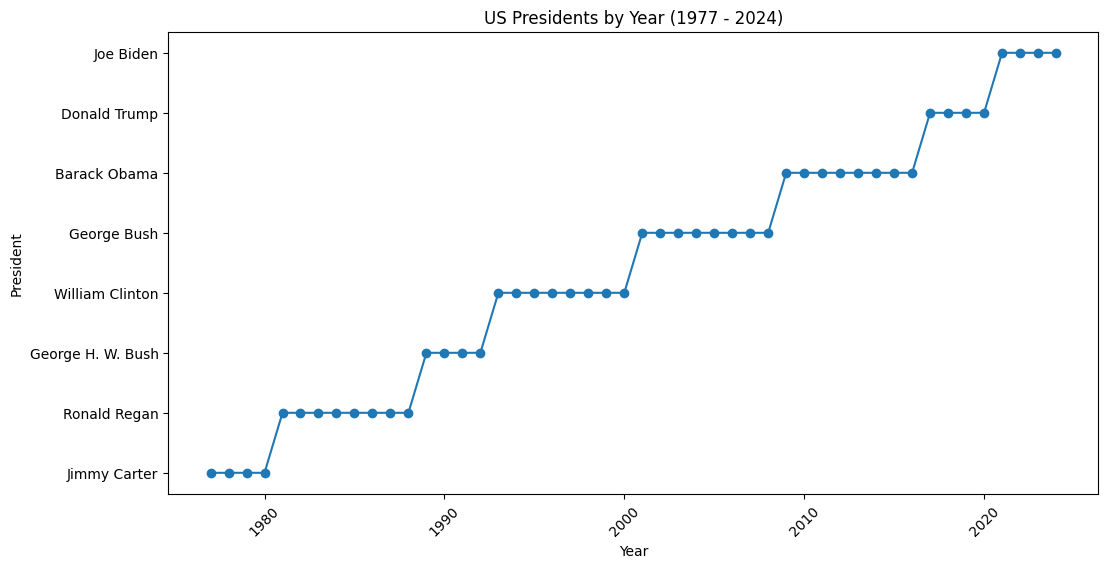

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(timeline_df['Year'], timeline_df['PresidentName'], marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('President')
plt.title('US Presidents by Year (1977 - 2024)')
plt.xticks(rotation=45)

# Display the plot
plt.show()

# Historical Data for Modeling

In [ ]:
modeling_df = pd.read_csv('/content/drive/MyDrive/1976-2020-president.csv')
modeling_df

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4282,2020,WYOMING,WY,56,83,68,US PRESIDENT,"JORGENSEN, JO",LIBERTARIAN,False,5768,278503,20210113,NaN,LIBERTARIAN
4283,2020,WYOMING,WY,56,83,68,US PRESIDENT,"PIERCE, BROCK",INDEPENDENT,False,2208,278503,20210113,NaN,OTHER
4284,2020,WYOMING,WY,56,83,68,US PRESIDENT,NaN,NaN,True,1739,278503,20210113,NaN,OTHER
4285,2020,WYOMING,WY,56,83,68,US PRESIDENT,OVERVOTES,NaN,False,279,278503,20210113,NaN,OTHER


Group by Presidential Winner per State by Year

In [ ]:
# Group by year and state, and find the candidate with the maximum votes in each group
winners = modeling_df.loc[modeling_df.groupby(['year', 'state'])['candidatevotes'].idxmax()]

# Create the table with desired columns
winner_table = winners[['year', 'state', 'candidate', 'party_detailed']]

# Display the table
print(winner_table)

      year          state            candidate party_detailed
0     1976        ALABAMA        CARTER, JIMMY       DEMOCRAT
7     1976         ALASKA         FORD, GERALD     REPUBLICAN
11    1976        ARIZONA         FORD, GERALD     REPUBLICAN
19    1976       ARKANSAS        CARTER, JIMMY       DEMOCRAT
23    1976     CALIFORNIA         FORD, GERALD     REPUBLICAN
...    ...            ...                  ...            ...
4252  2020       VIRGINIA  BIDEN, JOSEPH R. JR       DEMOCRAT
4256  2020     WASHINGTON  BIDEN, JOSEPH R. JR       DEMOCRAT
4264  2020  WEST VIRGINIA     TRUMP, DONALD J.     REPUBLICAN
4267  2020      WISCONSIN  BIDEN, JOSEPH R. JR       DEMOCRAT
4281  2020        WYOMING     TRUMP, DONALD J.     REPUBLICAN

[612 rows x 4 columns]


In [ ]:
print(len(winner_table))

612


# 2020 Election Winners

In [ ]:
# Filter for the year 2020
winner_2020 = winner_table[winner_table['year'] == 2020]
print(winner_2020)

      year                 state            candidate party_detailed
3741  2020               ALABAMA     TRUMP, DONALD J.     REPUBLICAN
3745  2020                ALASKA     TRUMP, DONALD J.     REPUBLICAN
3752  2020               ARIZONA  BIDEN, JOSEPH R. JR       DEMOCRAT
3771  2020              ARKANSAS     TRUMP, DONALD J.     REPUBLICAN
3773  2020            CALIFORNIA  BIDEN, JOSEPH R. JR       DEMOCRAT
3784  2020              COLORADO  BIDEN, JOSEPH R. JR       DEMOCRAT
3807  2020           CONNECTICUT  BIDEN, JOSEPH R. JR       DEMOCRAT
3838  2020              DELAWARE  BIDEN, JOSEPH R. JR       DEMOCRAT
3842  2020  DISTRICT OF COLUMBIA  BIDEN, JOSEPH R. JR       DEMOCRAT
3850  2020               FLORIDA     TRUMP, DONALD J.     REPUBLICAN
3878  2020               GEORGIA  BIDEN, JOSEPH R. JR       DEMOCRAT
3881  2020                HAWAII  BIDEN, JOSEPH R. JR       DEMOCRAT
3890  2020                 IDAHO     TRUMP, DONALD J.     REPUBLICAN
3904  2020              ILLINOIS  

In [ ]:
print(winner_2020.columns)


Index(['year', 'state', 'candidate', 'party_detailed'], dtype='object')


In [ ]:
print(winner_2020['candidate'].unique())

['TRUMP, DONALD J.' 'BIDEN, JOSEPH R. JR']


Mapping Abbreviations

In [ ]:
# Mapping of full state names to abbreviations
state_abbrev = {
    'ALABAMA': 'AL', 'ALASKA': 'AK', 'ARIZONA': 'AZ', 'ARKANSAS': 'AR',
    'CALIFORNIA': 'CA', 'COLORADO': 'CO', 'CONNECTICUT': 'CT', 'DELAWARE': 'DE',
    'DISTRICT OF COLUMBIA': 'DC', 'FLORIDA': 'FL', 'GEORGIA': 'GA', 'HAWAII': 'HI',
    'IDAHO': 'ID', 'ILLINOIS': 'IL', 'INDIANA': 'IN', 'IOWA': 'IA', 'KANSAS': 'KS',
    'KENTUCKY': 'KY', 'LOUISIANA': 'LA', 'MAINE': 'ME', 'MARYLAND': 'MD',
    'MASSACHUSETTS': 'MA', 'MICHIGAN': 'MI', 'MINNESOTA': 'MN', 'MISSISSIPPI': 'MS',
    'MISSOURI': 'MO', 'MONTANA': 'MT', 'NEBRASKA': 'NE', 'NEVADA': 'NV',
    'NEW HAMPSHIRE': 'NH', 'NEW JERSEY': 'NJ', 'NEW MEXICO': 'NM', 'NEW YORK': 'NY',
    'NORTH CAROLINA': 'NC', 'NORTH DAKOTA': 'ND', 'OHIO': 'OH', 'OKLAHOMA': 'OK',
    'OREGON': 'OR', 'PENNSYLVANIA': 'PA', 'RHODE ISLAND': 'RI', 'SOUTH CAROLINA': 'SC',
    'SOUTH DAKOTA': 'SD', 'TENNESSEE': 'TN', 'TEXAS': 'TX', 'UTAH': 'UT',
    'VERMONT': 'VT', 'VIRGINIA': 'VA', 'WASHINGTON': 'WA', 'WEST VIRGINIA': 'WV',
    'WISCONSIN': 'WI', 'WYOMING': 'WY'
}

winner_2020 = winner_2020.copy()

# Create a new column in the DataFrame with state abbreviations
winner_2020.loc[:, 'state_abbrev'] = winner_2020['state'].map(state_abbrev)

# Check for any NaNs
print(winner_2020[winner_2020['state_abbrev'].isna()])

Empty DataFrame
Columns: [year, state, candidate, party_detailed, state_abbrev]
Index: []


Plotting the 2020 Election Results by State


In [ ]:
# Plot US map with Plotly
fig = px.choropleth(
    winner_2020,
    locations='state_abbrev',  # Use state abbreviations
    locationmode='USA-states',
    color='candidate',  # Column for color coding
    color_discrete_map={'BIDEN, JOSEPH R. JR': 'blue', 'TRUMP, DONALD J.': 'red'},
    title='2020 US Election Winners by State',
    labels={'candidate': 'Election Winner'}
)

# Add state abbreviations as text labels
fig.add_scattergeo(
    locations=winner_2020['state_abbrev'],
    locationmode='USA-states',
    text=winner_2020['state_abbrev'],
    mode='text',
    textposition='middle center',
    showlegend=False
)

# Update layout for better readability
fig.update_layout(
    geo=dict(
        scope='usa',
        projection_type='albers usa',
        showland=True,
        landcolor='lightgray',
        subunitcolor='black'
    ),
    legend_title='Winner'
)

fig.show()

# 2016 Election Winners

In [ ]:
# Filter for the year 2020
winner_2016 = winner_table[winner_table['year'] == 2016]
print(winner_2016)

      year                 state         candidate party_detailed
3395  2016               ALABAMA  TRUMP, DONALD J.     REPUBLICAN
3400  2016                ALASKA  TRUMP, DONALD J.     REPUBLICAN
3407  2016               ARIZONA  TRUMP, DONALD J.     REPUBLICAN
3417  2016              ARKANSAS  TRUMP, DONALD J.     REPUBLICAN
3425  2016            CALIFORNIA  CLINTON, HILLARY       DEMOCRAT
3431  2016              COLORADO  CLINTON, HILLARY       DEMOCRAT
3451  2016           CONNECTICUT  CLINTON, HILLARY       DEMOCRAT
3456  2016              DELAWARE  CLINTON, HILLARY       DEMOCRAT
3460  2016  DISTRICT OF COLUMBIA  CLINTON, HILLARY       DEMOCRAT
3467  2016               FLORIDA  TRUMP, DONALD J.     REPUBLICAN
3474  2016               GEORGIA  TRUMP, DONALD J.     REPUBLICAN
3478  2016                HAWAII  CLINTON, HILLARY       DEMOCRAT
3485  2016                 IDAHO  TRUMP, DONALD J.     REPUBLICAN
3490  2016              ILLINOIS  CLINTON, HILLARY       DEMOCRAT
3495  2016

In [ ]:
print(winner_2016.columns)

Index(['year', 'state', 'candidate', 'party_detailed'], dtype='object')


In [ ]:
# Mapping of full state names to abbreviations
state_abbrev = {
    'ALABAMA': 'AL', 'ALASKA': 'AK', 'ARIZONA': 'AZ', 'ARKANSAS': 'AR',
    'CALIFORNIA': 'CA', 'COLORADO': 'CO', 'CONNECTICUT': 'CT', 'DELAWARE': 'DE',
    'DISTRICT OF COLUMBIA': 'DC', 'FLORIDA': 'FL', 'GEORGIA': 'GA', 'HAWAII': 'HI',
    'IDAHO': 'ID', 'ILLINOIS': 'IL', 'INDIANA': 'IN', 'IOWA': 'IA', 'KANSAS': 'KS',
    'KENTUCKY': 'KY', 'LOUISIANA': 'LA', 'MAINE': 'ME', 'MARYLAND': 'MD',
    'MASSACHUSETTS': 'MA', 'MICHIGAN': 'MI', 'MINNESOTA': 'MN', 'MISSISSIPPI': 'MS',
    'MISSOURI': 'MO', 'MONTANA': 'MT', 'NEBRASKA': 'NE', 'NEVADA': 'NV',
    'NEW HAMPSHIRE': 'NH', 'NEW JERSEY': 'NJ', 'NEW MEXICO': 'NM', 'NEW YORK': 'NY',
    'NORTH CAROLINA': 'NC', 'NORTH DAKOTA': 'ND', 'OHIO': 'OH', 'OKLAHOMA': 'OK',
    'OREGON': 'OR', 'PENNSYLVANIA': 'PA', 'RHODE ISLAND': 'RI', 'SOUTH CAROLINA': 'SC',
    'SOUTH DAKOTA': 'SD', 'TENNESSEE': 'TN', 'TEXAS': 'TX', 'UTAH': 'UT',
    'VERMONT': 'VT', 'VIRGINIA': 'VA', 'WASHINGTON': 'WA', 'WEST VIRGINIA': 'WV',
    'WISCONSIN': 'WI', 'WYOMING': 'WY'
}

winner_2016 = winner_2016.copy()

# Create a new column in the DataFrame with state abbreviations
winner_2016.loc[:, 'state_abbrev'] = winner_2016['state'].map(state_abbrev)

# Check for any NaNs
print(winner_2016[winner_2016['state_abbrev'].isna()])

Empty DataFrame
Columns: [year, state, candidate, party_detailed, state_abbrev]
Index: []


Plotting the 2020 Election Results by State

In [ ]:
# Plot US map with Plotly
fig = px.choropleth(
    winner_2016,
    locations='state_abbrev',
    locationmode='USA-states',
    color='candidate',
    color_discrete_map={'CLINTON, HILLARY': 'blue', 'TRUMP, DONALD J.': 'red'},
    title='2016 US Election Winners by State',
    labels={'candidate': 'Election Winner'}
)

# Add state abbreviations as text labels
fig.add_scattergeo(
    locations=winner_2016['state_abbrev'],
    locationmode='USA-states',
    text=winner_2016['state_abbrev'],
    mode='text',
    textposition='middle center',
    showlegend=False
)

# Update layout for better readability
fig.update_layout(
    geo=dict(
        scope='usa',
        projection_type='albers usa',
        showland=True,
        landcolor='lightgray',
        subunitcolor='black'
    ),
    legend_title='Winner'
)

fig.show()

# EDA


In [ ]:
# Display basic info about the dataset
print(modeling_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4287 entries, 0 to 4286
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              4287 non-null   int64  
 1   state             4287 non-null   object 
 2   state_po          4287 non-null   object 
 3   state_fips        4287 non-null   int64  
 4   state_cen         4287 non-null   int64  
 5   state_ic          4287 non-null   int64  
 6   office            4287 non-null   object 
 7   candidate         4000 non-null   object 
 8   party_detailed    3831 non-null   object 
 9   writein           4284 non-null   object 
 10  candidatevotes    4287 non-null   int64  
 11  totalvotes        4287 non-null   int64  
 12  version           4287 non-null   int64  
 13  notes             0 non-null      float64
 14  party_simplified  4287 non-null   object 
dtypes: float64(1), int64(7), object(7)
memory usage: 502.5+ KB
None


In [ ]:
# Display summary statistics - numerical columns
print(modeling_df.describe())

              year   state_fips    state_cen     state_ic  candidatevotes  \
count  4287.000000  4287.000000  4287.000000  4287.000000    4.287000e+03   
mean   1999.080942    28.616982    53.665034    39.754840    3.119076e+05   
std      14.220014    15.616459    26.029189    22.772216    7.648011e+05   
min    1976.000000     1.000000    11.000000     1.000000    0.000000e+00   
25%    1988.000000    16.000000    33.000000    22.000000    1.177000e+03   
50%    2000.000000    28.000000    53.000000    42.000000    7.499000e+03   
75%    2012.000000    41.000000    81.000000    61.000000    1.992415e+05   
max    2020.000000    56.000000    95.000000    82.000000    1.111025e+07   

         totalvotes     version  notes  
count  4.287000e+03      4287.0    0.0  
mean   2.366924e+06  20210113.0    NaN  
std    2.465008e+06         0.0    NaN  
min    1.235740e+05  20210113.0    NaN  
25%    6.522740e+05  20210113.0    NaN  
50%    1.569180e+06  20210113.0    NaN  
75%    3.033118e+06

Summary statistics for categorical columns

In [ ]:
categorical_columns = ['state', 'state_po', 'office', 'candidate', 'party_detailed', 'writein', 'party_simplified']

for col in categorical_columns:
    print(f'\nSummary statistics for {col}:')


    # Value counts
    value_counts = modeling_df[col].value_counts()
    print('Value Counts:')
    print(value_counts)


Summary statistics for state:
Value Counts:
state
COLORADO                149
NEW YORK                145
MINNESOTA               128
IOWA                    124
VERMONT                 122
UTAH                    114
WASHINGTON              106
NEW JERSEY              104
LOUISIANA               102
WISCONSIN               101
ILLINOIS                 97
RHODE ISLAND             95
KENTUCKY                 94
FLORIDA                  94
MARYLAND                 92
MICHIGAN                 91
NEW HAMPSHIRE            90
ARKANSAS                 90
OHIO                     89
DISTRICT OF COLUMBIA     87
MASSACHUSETTS            86
CALIFORNIA               85
NEW MEXICO               85
DELAWARE                 83
NORTH DAKOTA             80
MISSISSIPPI              80
ARIZONA                  79
TENNESSEE                78
ALASKA                   78
CONNECTICUT              76
MAINE                    74
OREGON                   74
HAWAII                   73
NEVADA                   

Summary statistics for categorical columns

In [ ]:
categorical_columns = ['party_detailed', 'party_simplified']

for col in categorical_columns:
    print(f'\nSummary statistics for {col}:')

    # Value counts
    value_counts = modeling_df[col].value_counts()
    print('Value Counts:')
    print(value_counts)


Summary statistics for party_detailed:
Value Counts:
party_detailed
REPUBLICAN                613
DEMOCRAT                  612
LIBERTARIAN               535
INDEPENDENT               405
GREEN                     211
                         ... 
PATRIOT PARTY               1
REFORM PARTY MINNESOTA      1
CITIZENS FIRST              1
PROGRESSIVE/GREEN           1
VERMONT GRASSROOTS          1
Name: count, Length: 172, dtype: int64

Summary statistics for party_simplified:
Value Counts:
party_simplified
OTHER          2524
DEMOCRAT        615
REPUBLICAN      613
LIBERTARIAN     535
Name: count, dtype: int64


Comverting Minority Parties in the Party Detailed Column to Other

In [ ]:
party_counts = modeling_df['party_detailed'].value_counts()

# Create a mapping where parties with fewer than 300 counts are labeled 'OTHER'
party_mapping = {party: 'OTHER' if count < 300 else party for party, count in party_counts.items()}

# Replace values in 'party_detailed' based on the mapping
modeling_df['party_detailed'] = modeling_df['party_detailed'].map(party_mapping)
print(modeling_df['party_detailed'].value_counts())

party_detailed
OTHER          1666
REPUBLICAN      613
DEMOCRAT        612
LIBERTARIAN     535
INDEPENDENT     405
Name: count, dtype: int64


Proportions of parties in party_simplified column

In [ ]:
proportions = modeling_df[col].value_counts(normalize=True)
print('Proportions:')
print(proportions)

Proportions:
party_simplified
OTHER          0.588757
DEMOCRAT       0.143457
REPUBLICAN     0.142990
LIBERTARIAN    0.124796
Name: proportion, dtype: float64


In [ ]:
# Summary of unique values and frequencies
unique_values = modeling_df[col].unique()
num_unique = len(unique_values)
print(f'Number of unique values: {num_unique}')
print(f'Unique values: {unique_values}')

Number of unique values: 4
Unique values: ['DEMOCRAT' 'REPUBLICAN' 'OTHER' 'LIBERTARIAN']


Plotting the party_simplified and party_detailed columns

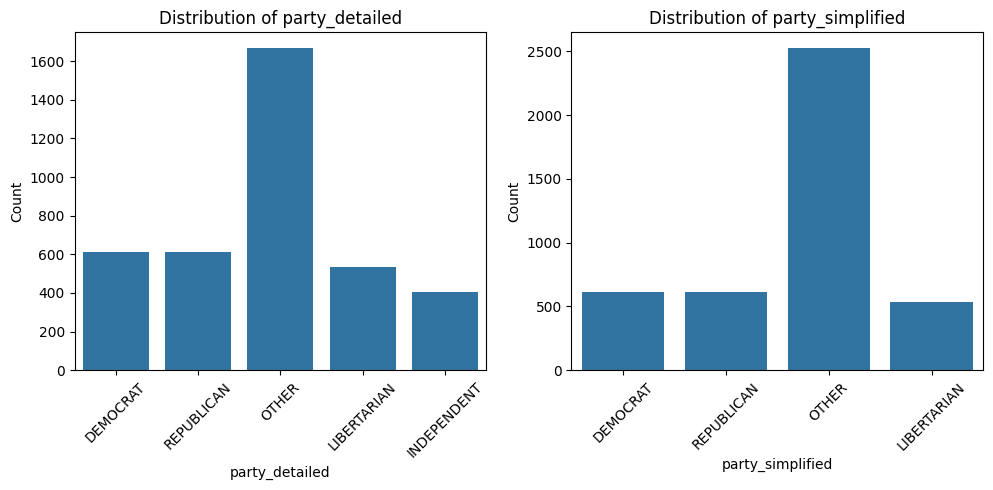

In [ ]:
# Determine the number of plots needed
n = len(categorical_columns)
nrows = (n + 2) // 3  # Number of rows, with 3 columns per row

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Plot count plots for each categorical column
for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=modeling_df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots (if there are fewer plots than subplots)
for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

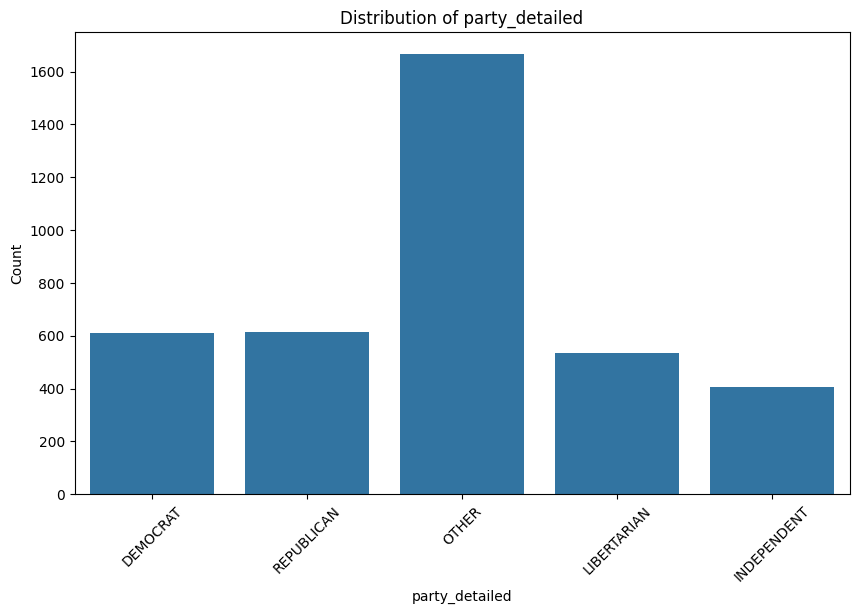

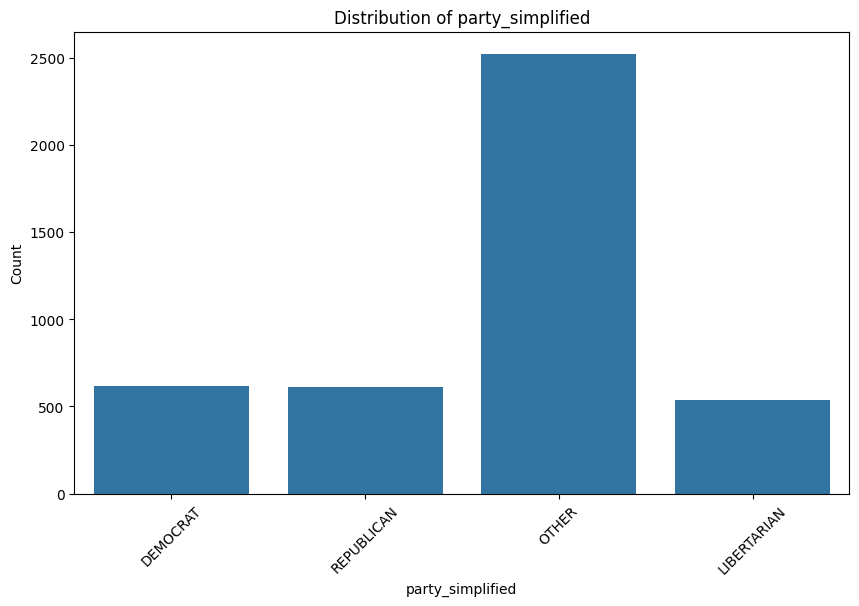

In [ ]:
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=modeling_df)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

Plotting frequency for numerical columns

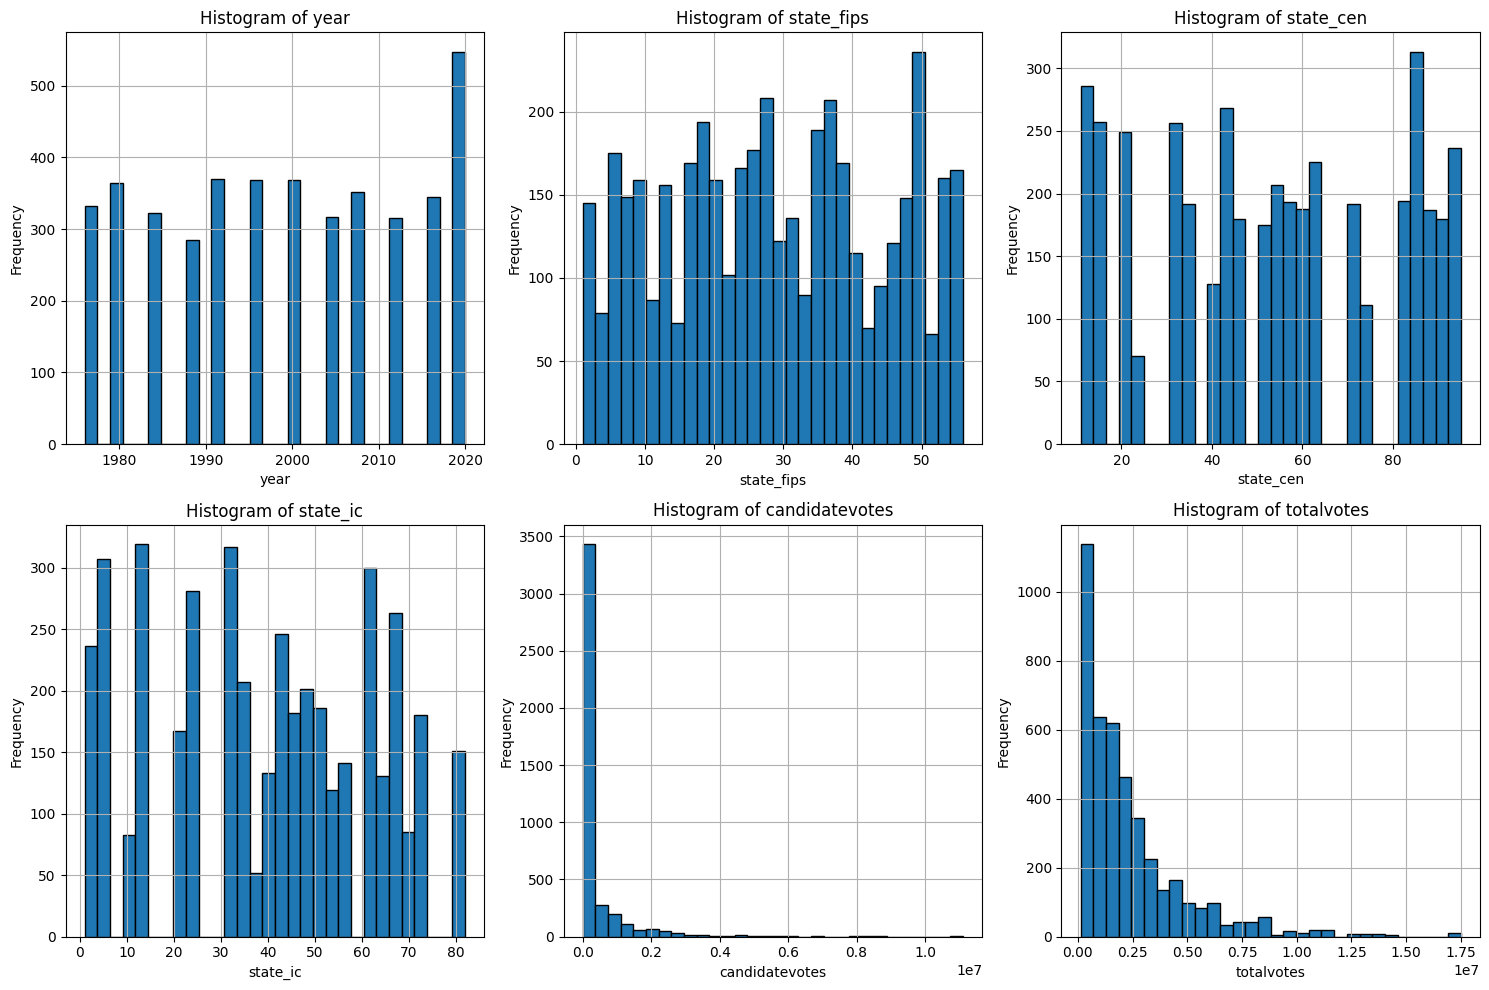

In [ ]:
numerical_columns = ['year', 'state_fips', 'state_cen', 'state_ic', 'candidatevotes', 'totalvotes']

# Determine the number of plots needed
n = len(numerical_columns)
nrows = (n + 2) // 3  # Number of rows, with 3 columns per row

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Plot histograms for each numerical column
for i, col in enumerate(numerical_columns):
    axes[i].hist(modeling_df[col], bins=30, edgecolor='k')
    axes[i].set_xlabel(col)  # Set xlabel to the column name
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].grid(True)

# Remove any unused subplots (if there are fewer plots than subplots)
for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

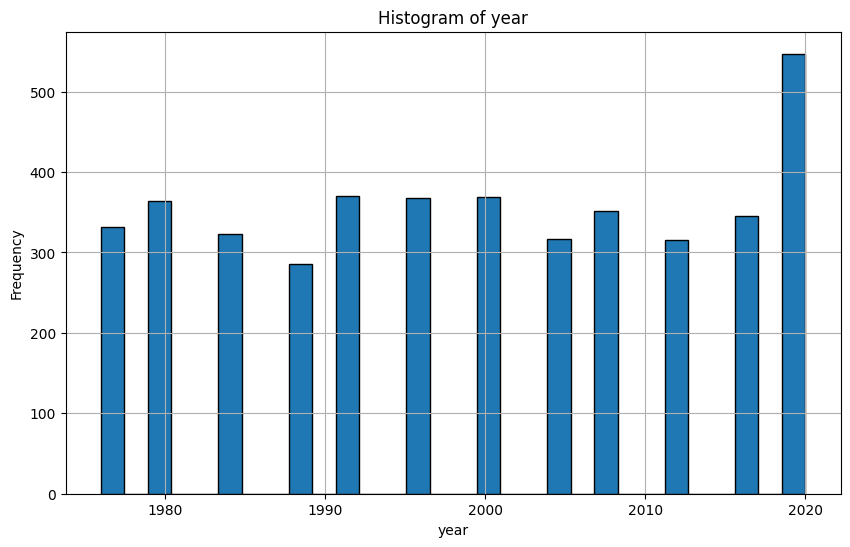

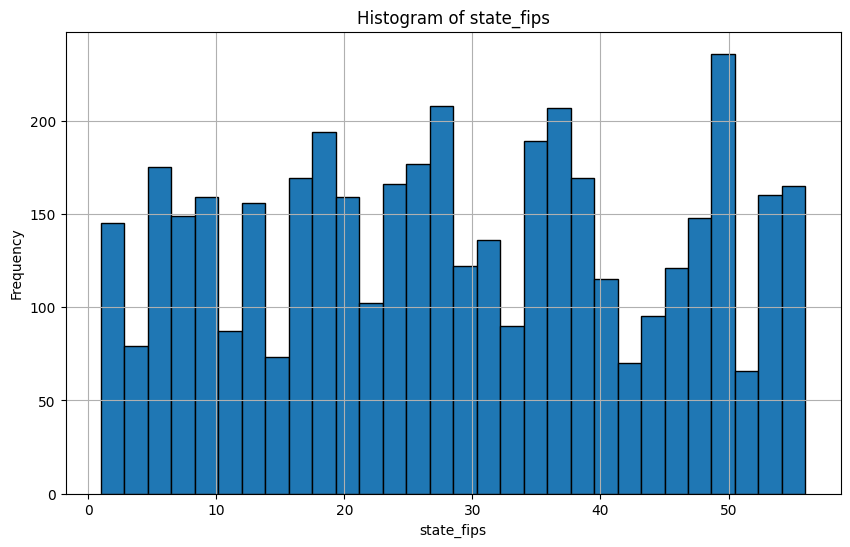

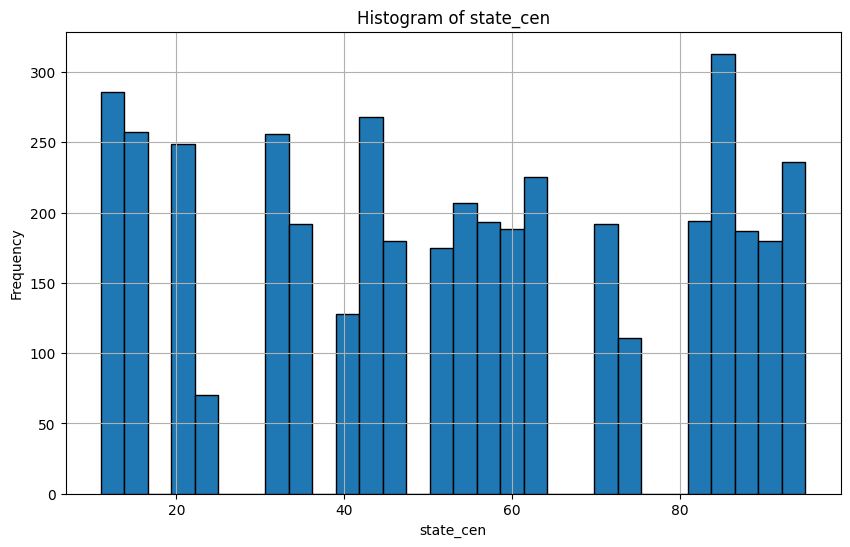

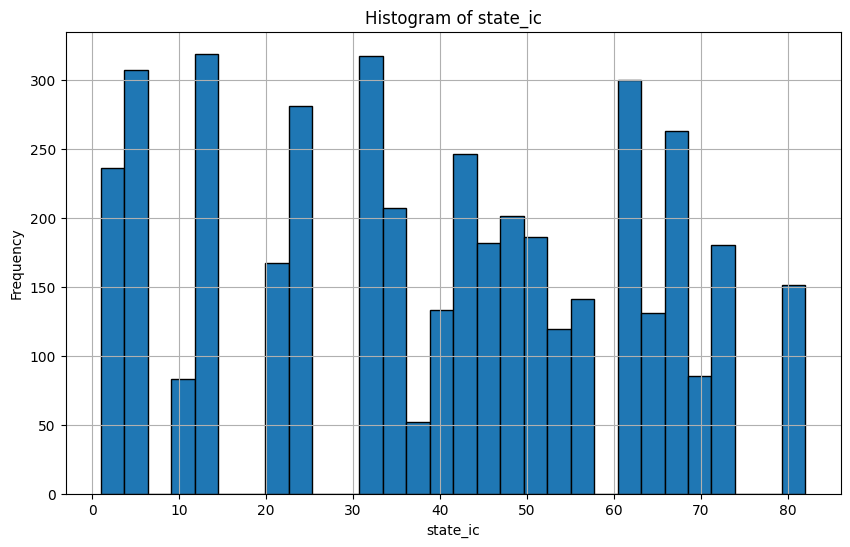

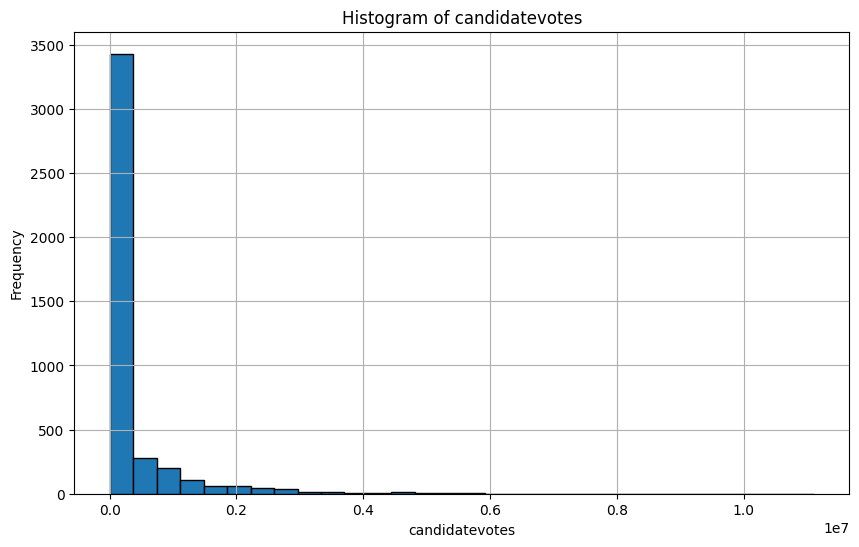

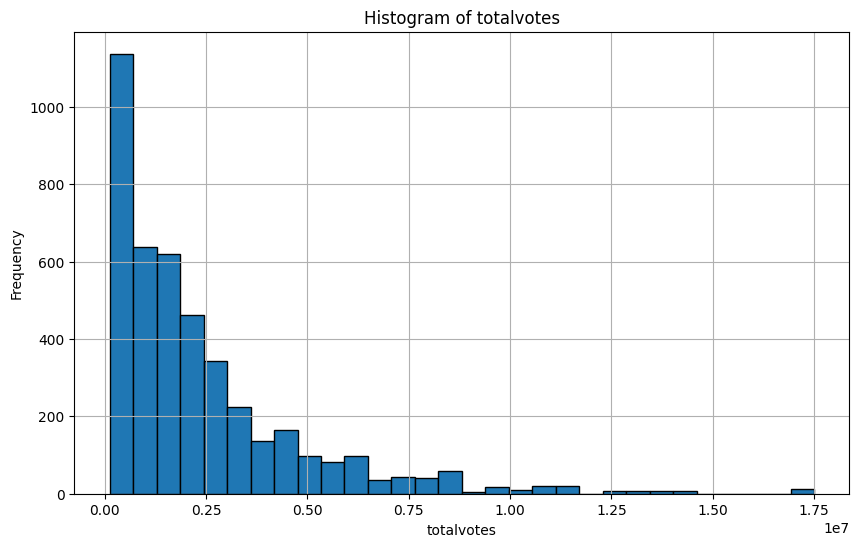

In [ ]:
numerical_columns = ['year', 'state_fips', 'state_cen', 'state_ic', 'candidatevotes', 'totalvotes']

# Plot histograms for each numerical column
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    plt.hist(modeling_df[col], bins=30, edgecolor='k')
    plt.xlabel(col)  # Set xlabel to the column name
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
    plt.grid(True)
    plt.show()


Checking for missing data per row
> Won't be using the candidate column, party_detailed, writein, or notes columns in the project so wont need to handle missing values in those columns.

In [ ]:
# Check for missing values
print(modeling_df.isnull().sum())

year                   0
state                  0
state_po               0
state_fips             0
state_cen              0
state_ic               0
office                 0
candidate            287
party_detailed       456
writein                3
candidatevotes         0
totalvotes             0
version                0
notes               4287
party_simplified       0
dtype: int64


Checking for duplicate rows

In [ ]:
# Check for duplicates
print(modeling_df.duplicated().sum())

0


# Preprocessing

Adding a Column for State Number (Assigned by Order of Admission into the Union) - Preprocessing the state column

In [ ]:
modeling = modeling_df.copy()

In [ ]:
print(modeling['state_po'].unique())

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID' 'IL'
 'IN' 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE'
 'NV' 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


Assigning State numbers to the state abbreviations, based on order of admission into the union.

In [ ]:
# Mapping state abbreviations based on order of admission into the Union
state_admission_order = {
    'DE': 1, 'PA': 2, 'NJ': 3, 'GA': 4, 'CT': 5,
    'MA': 6, 'MD': 7, 'SC': 8, 'NH': 9, 'VA': 10,
    'NY': 11, 'NC': 12, 'RI': 13, 'VT': 14, 'KY': 15,
    'TN': 16, 'OH': 17, 'LA': 18, 'IN': 19, 'MS': 20,
    'IL': 21, 'AL': 22, 'ME': 23, 'MO': 24, 'AR': 25,
    'MI': 26, 'FL': 27, 'TX': 28, 'IA': 29, 'WI': 30,
    'CA': 31, 'MN': 32, 'OR': 33, 'KS': 34, 'WV': 35,
    'NV': 36, 'NE': 37, 'CO': 38, 'ND': 39, 'SD': 40,
    'MT': 41, 'WA': 42, 'ID': 43, 'WY': 44, 'UT': 45,
    'OK': 46, 'NM': 47, 'AZ': 48, 'AK': 49, 'HI': 50
}

In [ ]:
# Map state abbreviations to their order of admission
modeling['state_num'] = modeling['state_po'].map(state_admission_order)

# Check for any missing values in the new column
missing_states = modeling[modeling['state_num'].isna()]['state_po'].unique()
print(f'Missing state abbreviations: {missing_states}')

Missing state abbreviations: ['DC']


Adding State Number column

In [ ]:
modeling = modeling.dropna(subset=['state_num'])

In [ ]:
modeling

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified,state_num
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT,22.0
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN,22.0
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",OTHER,False,9198,1182850,20210113,NaN,OTHER,22.0
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",OTHER,False,6669,1182850,20210113,NaN,OTHER,22.0
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",OTHER,False,1954,1182850,20210113,NaN,OTHER,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4282,2020,WYOMING,WY,56,83,68,US PRESIDENT,"JORGENSEN, JO",LIBERTARIAN,False,5768,278503,20210113,NaN,LIBERTARIAN,44.0
4283,2020,WYOMING,WY,56,83,68,US PRESIDENT,"PIERCE, BROCK",INDEPENDENT,False,2208,278503,20210113,NaN,OTHER,44.0
4284,2020,WYOMING,WY,56,83,68,US PRESIDENT,NaN,NaN,True,1739,278503,20210113,NaN,OTHER,44.0
4285,2020,WYOMING,WY,56,83,68,US PRESIDENT,OVERVOTES,NaN,False,279,278503,20210113,NaN,OTHER,44.0


Preprocessing the party_simplified column - Using Label Encoder


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
modeling.loc[:, 'party_encoded'] = label_encoder.fit_transform(modeling['party_simplified'])

# Verify the new column
print(modeling[['party_simplified', 'party_encoded']].head())


  party_simplified  party_encoded
0         DEMOCRAT              0
1       REPUBLICAN              3
2            OTHER              2
3            OTHER              2
4            OTHER              2


In [ ]:
modeling

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified,state_num,party_encoded
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT,22.0,0
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN,22.0,3
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",OTHER,False,9198,1182850,20210113,NaN,OTHER,22.0,2
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",OTHER,False,6669,1182850,20210113,NaN,OTHER,22.0,2
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",OTHER,False,1954,1182850,20210113,NaN,OTHER,22.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4282,2020,WYOMING,WY,56,83,68,US PRESIDENT,"JORGENSEN, JO",LIBERTARIAN,False,5768,278503,20210113,NaN,LIBERTARIAN,44.0,1
4283,2020,WYOMING,WY,56,83,68,US PRESIDENT,"PIERCE, BROCK",INDEPENDENT,False,2208,278503,20210113,NaN,OTHER,44.0,2
4284,2020,WYOMING,WY,56,83,68,US PRESIDENT,NaN,NaN,True,1739,278503,20210113,NaN,OTHER,44.0,2
4285,2020,WYOMING,WY,56,83,68,US PRESIDENT,OVERVOTES,NaN,False,279,278503,20210113,NaN,OTHER,44.0,2


Adding a vote percentage column and determining the winning party per state based on percentage of votes.

In [ ]:
# Convert relevant columns to appropriate data types
modeling.loc[:, 'year'] = modeling['year'].astype(int)
modeling.loc[:, 'candidatevotes'] = modeling['candidatevotes'].astype(int)
modeling.loc[:, 'totalvotes'] = modeling['totalvotes'].astype(int)

# Create a new column for the vote percentage
modeling.loc[:, 'vote_percentage'] = modeling['candidatevotes'] / modeling['totalvotes'] * 100

# Create a column for the winning candidate in each state for each year
modeling.loc[:, 'winner'] = modeling.groupby(['year', 'state'])['candidatevotes'].transform(max) == modeling['candidatevotes']

# Verify the changes
print(modeling.head())

   year    state state_po  state_fips  state_cen  state_ic        office  \
0  1976  ALABAMA       AL           1         63        41  US PRESIDENT   
1  1976  ALABAMA       AL           1         63        41  US PRESIDENT   
2  1976  ALABAMA       AL           1         63        41  US PRESIDENT   
3  1976  ALABAMA       AL           1         63        41  US PRESIDENT   
4  1976  ALABAMA       AL           1         63        41  US PRESIDENT   

                 candidate party_detailed writein  candidatevotes  totalvotes  \
0            CARTER, JIMMY       DEMOCRAT   False          659170     1182850   
1             FORD, GERALD     REPUBLICAN   False          504070     1182850   
2           MADDOX, LESTER          OTHER   False            9198     1182850   
3  BUBAR, BENJAMIN ""BEN""          OTHER   False            6669     1182850   
4                HALL, GUS          OTHER   False            1954     1182850   

    version  notes party_simplified  state_num  party_en

<ipython-input-41-306e0acd433f>:10: FutureWarning:

The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.



In [ ]:
modeling.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified,state_num,party_encoded,vote_percentage,winner
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT,22.0,0,55.727269,True
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN,22.0,3,42.614871,False
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",OTHER,False,9198,1182850,20210113,NaN,OTHER,22.0,2,0.777613,False
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",OTHER,False,6669,1182850,20210113,NaN,OTHER,22.0,2,0.563808,False
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",OTHER,False,1954,1182850,20210113,NaN,OTHER,22.0,2,0.165194,False


Dropping unnecessary columns

In [ ]:
modeling.drop(columns=['notes', 'writein', 'office', 'version'], inplace=True)

Mapping Winner column to winning party

In [ ]:
# Create a mapping from (year, state) to party
winner_mapping = winner_table.set_index(['year', 'state'])['party_detailed'].to_dict()

# Function to get the winning party
def get_winner_party(row):
    if row['winner']:
        return winner_mapping.get((row['year'], row['state']), 'Unknown')
    else:
        return None

# Apply the function to create the new 'winner_party' column
modeling['winner_party'] = modeling.apply(get_winner_party, axis=1)

# Verify the changes
print(modeling.head())

   year    state state_po  state_fips  state_cen  state_ic  \
0  1976  ALABAMA       AL           1         63        41   
1  1976  ALABAMA       AL           1         63        41   
2  1976  ALABAMA       AL           1         63        41   
3  1976  ALABAMA       AL           1         63        41   
4  1976  ALABAMA       AL           1         63        41   

                 candidate party_detailed  candidatevotes  totalvotes  \
0            CARTER, JIMMY       DEMOCRAT          659170     1182850   
1             FORD, GERALD     REPUBLICAN          504070     1182850   
2           MADDOX, LESTER          OTHER            9198     1182850   
3  BUBAR, BENJAMIN ""BEN""          OTHER            6669     1182850   
4                HALL, GUS          OTHER            1954     1182850   

  party_simplified  state_num  party_encoded  vote_percentage  winner  \
0         DEMOCRAT       22.0              0        55.727269    True   
1       REPUBLICAN       22.0             

In [ ]:
modeling[['year', 'state', 'winner_party']].sort_values(by=['year', 'state']).to_csv('winner_party_list.csv', index=False)
modeling.head()

,year,state,state_po,state_fips,state_cen,state_ic,candidate,party_detailed,candidatevotes,totalvotes,party_simplified,state_num,party_encoded,vote_percentage,winner,winner_party
0,1976,ALABAMA,AL,1,63,41,"CARTER, JIMMY",DEMOCRAT,659170,1182850,DEMOCRAT,22.0,0,55.727269,True,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,"FORD, GERALD",REPUBLICAN,504070,1182850,REPUBLICAN,22.0,3,42.614871,False,None
2,1976,ALABAMA,AL,1,63,41,"MADDOX, LESTER",OTHER,9198,1182850,OTHER,22.0,2,0.777613,False,None
3,1976,ALABAMA,AL,1,63,41,"BUBAR, BENJAMIN """"BEN""""",OTHER,6669,1182850,OTHER,22.0,2,0.563808,False,None
4,1976,ALABAMA,AL,1,63,41,"HALL, GUS",OTHER,1954,1182850,OTHER,22.0,2,0.165194,False,None


Checking for missing data in the new columns

In [ ]:
# Check for missing values
print(modeling.isnull().sum())

year                   0
state                  0
state_po               0
state_fips             0
state_cen              0
state_ic               0
candidate            274
party_detailed       441
candidatevotes         0
totalvotes             0
party_simplified       0
state_num              0
party_encoded          0
vote_percentage        0
winner                 0
winner_party        3600
dtype: int64


In [ ]:
print(modeling[modeling['candidate'].isna()])


      year       state state_po  state_fips  state_cen  state_ic candidate  \
6     1976     ALABAMA       AL           1         63        41       NaN   
10    1976      ALASKA       AK           2         94        81       NaN   
18    1976     ARIZONA       AZ           4         86        61       NaN   
21    1976    ARKANSAS       AR           5         71        42       NaN   
45    1976    DELAWARE       DE          10         51        11       NaN   
...    ...         ...      ...         ...        ...       ...       ...   
4248  2020     VERMONT       VT          50         13         6       NaN   
4255  2020    VIRGINIA       VA          51         54        40       NaN   
4262  2020  WASHINGTON       WA          53         91        73       NaN   
4279  2020   WISCONSIN       WI          55         35        25       NaN   
4284  2020     WYOMING       WY          56         83        68       NaN   

     party_detailed  candidatevotes  totalvotes party_simplifie

Handling Missing Data in New columns

In [ ]:
# Check if any NaNs are associated with winners
# Step 1: Filter rows where 'candidate' is NaN
missing_candidate_rows = modeling[modeling['candidate'].isna()]

# Step 2: Check if any of these rows have 'winner' column as True
associated_winner_true = missing_candidate_rows['winner'].any()

# Output the result
if associated_winner_true:
    print("There are rows with missing candidates that are associated with a True value in the winner column.")
else:
    print("No rows with missing candidates are associated with a True value in the winner column.")


No rows with missing candidates are associated with a True value in the winner column.


In [ ]:
# Assigning Unknown to NaNs in the candidate column
modeling['candidate'].fillna('UNKNOWN', inplace=True)

In [ ]:
print(modeling[modeling['party_detailed'].isna()])

      year        state state_po  state_fips  state_cen  state_ic   candidate  \
6     1976      ALABAMA       AL           1         63        41     UNKNOWN   
10    1976       ALASKA       AK           2         94        81     UNKNOWN   
18    1976      ARIZONA       AZ           4         86        61     UNKNOWN   
40    1976  CONNECTICUT       CT           9         16         1  SCATTERING   
59    1976      FLORIDA       FL          12         59        43     UNKNOWN   
...    ...          ...      ...         ...        ...       ...         ...   
4262  2020   WASHINGTON       WA          53         91        73     UNKNOWN   
4279  2020    WISCONSIN       WI          55         35        25     UNKNOWN   
4284  2020      WYOMING       WY          56         83        68     UNKNOWN   
4285  2020      WYOMING       WY          56         83        68   OVERVOTES   
4286  2020      WYOMING       WY          56         83        68  UNDERVOTES   

     party_detailed  candid

In [ ]:
# Assigning Unknown to NaNs in the party_detailed column
modeling['party_detailed'].fillna('UNKNOWN', inplace=True)

In [ ]:
# Assigning Lost to NaNs in the Winner column
modeling['winner_party'].fillna('Lost', inplace=True)

In [ ]:
# Check for missing values - after imputing
print(modeling.isnull().sum())

year                0
state               0
state_po            0
state_fips          0
state_cen           0
state_ic            0
candidate           0
party_detailed      0
candidatevotes      0
totalvotes          0
party_simplified    0
state_num           0
party_encoded       0
vote_percentage     0
winner              0
winner_party        0
dtype: int64


Subsetting data set

In [ ]:
subset_columns = ['year', 'state_num', 'party_encoded', 'candidatevotes', 'totalvotes', 'winner_party']
data = modeling[subset_columns]
data

,year,state_num,party_encoded,candidatevotes,totalvotes,winner_party
0,1976,22.0,0,659170,1182850,DEMOCRAT
1,1976,22.0,3,504070,1182850,Lost
2,1976,22.0,2,9198,1182850,Lost
3,1976,22.0,2,6669,1182850,Lost
4,1976,22.0,2,1954,1182850,Lost
...,...,...,...,...,...,...
4282,2020,44.0,1,5768,278503,Lost
4283,2020,44.0,2,2208,278503,Lost
4284,2020,44.0,2,1739,278503,Lost
4285,2020,44.0,2,279,278503,Lost


In [ ]:
data['winner_party'] = data['winner_party'].replace('DEMOCRATIC-FARMER-LABOR', 'DEMOCRAT')

<ipython-input-55-b9c0be346932>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Check for missing values - after converting column
print(data.isnull().sum())

year              0
state_num         0
party_encoded     0
candidatevotes    0
totalvotes        0
winner_party      0
dtype: int64


In [ ]:
parties = list(modeling.party_simplified.unique())
df_year_party = pd.DataFrame(columns=["year"] + parties)

for year in modeling_df.year.unique():
    row = {"year": year}
    for party in parties:
        row[party] = modeling_df[(modeling_df.year == year) & (modeling_df.party_simplified == party)].candidatevotes.sum()
    df_year_party = pd.concat([df_year_party, pd.DataFrame([row])], ignore_index=True)

df_year_party["votes_casted"] = df_year_party[parties].sum(axis=1)

df_year_party = df_year_party.astype(np.uint32)
df_year_party.year = df_year_party.year.astype(np.uint16)

df_year_party.set_index('year', inplace=True)
df_year_party

,DEMOCRAT,REPUBLICAN,OTHER,LIBERTARIAN,votes_casted
year,,,,,
1976,40680446,38870893,1954379,95626,81601344
1980,35480948,43642639,6505863,867401,86496851
1984,37449813,54166829,811015,227204,92654861
1988,41716679,48642640,817798,409708,91586825
1992,44856747,38798913,20663272,280848,104599780
1996,47295351,39003697,9625419,465351,96389818
2000,50830580,50311372,4071625,380405,105593982
2004,58894561,61872711,1212870,369308,122349450
2008,69338846,59613835,1956116,510456,131419253


In [ ]:
def line_plot(data_dict: dict, title: str):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))  # Adjust figure size here
    for label, data in data_dict.items():
        sns.lineplot(data=data, label=label)

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("% votes")
    plt.xticks(ticks=data.index, labels=data.index, rotation=-30)
    plt.xlim(data.index.min(), data.index.max())
    plt.legend(title='Party')
    plt.grid(True)
    plt.show()

# % of votes per party per year (out of total votes casted)
data_democrat = df_year_party.DEMOCRAT / df_year_party.votes_casted * 100
data_replublican = df_year_party.REPUBLICAN / df_year_party.votes_casted * 100
data_other = df_year_party.OTHER / df_year_party.votes_casted * 100
data_libertarian = df_year_party.LIBERTARIAN / df_year_party.votes_casted * 100

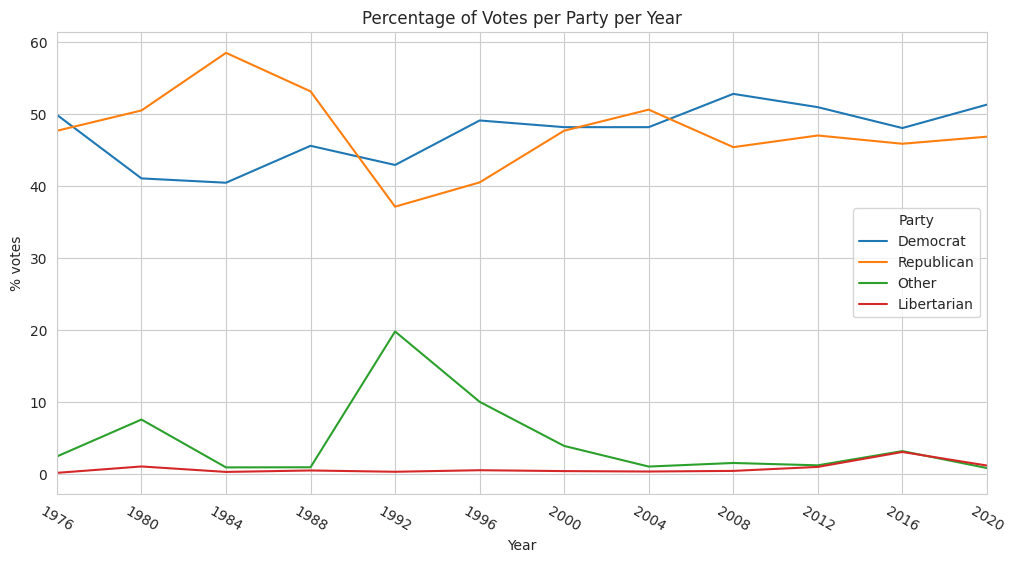

In [ ]:
# Create a dictionary of data for each party
data_dict = {
    'Democrat': data_democrat,
    'Republican': data_replublican,
    'Other': data_other,
    'Libertarian': data_libertarian
}

# Call the modified line_plot function
line_plot(data_dict, 'Percentage of Votes per Party per Year')

# Model Selection and Training

# Train Test Split for 2020 Predictions (Based on only 2020 Data)

In [ ]:
# Filter for the year 2020
df_2020 = modeling_df[modeling_df['year'] == 2020]

# Find the party with the maximum votes per state
winner_2020 = df_2020.loc[df_2020.groupby('state')['candidatevotes'].idxmax()]
winner_2020 = winner_2020[['state', 'year', 'party_simplified']]

# Prepare features
features = df_2020[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features = pd.get_dummies(features, columns=['party_simplified'])

# Prepare labels
labels = winner_2020[['state', 'year', 'party_simplified']]

# Encode the labels
label_encoder = LabelEncoder()
labels['party_simplified'] = label_encoder.fit_transform(labels['party_simplified'])

# Merge features and labels
data = features.merge(labels, on=['state', 'year'])

# Split the data into features and labels
X = data.drop(['state', 'year', 'party_simplified'], axis=1)
y = data['party_simplified']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Random Forest - 2020 ONLY Data

In [ ]:
# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

# Prepare features for prediction
prediction_features = pd.get_dummies(df_2020[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']], columns=['party_simplified'])
prediction_features = prediction_features.reindex(columns=X.columns, fill_value=0)

# Predict
predictions = model.predict(prediction_features)

# Map predictions back to party names
predictions = label_encoder.inverse_transform(predictions)

# Combine states, year, and predictions
results = pd.DataFrame({'state': df_2020['state'].values, 'year': df_2020['year'].values, 'predicted_party': predictions})

# Find actual winners
actual_winners = winner_2020[['state', 'year', 'party_simplified']].rename(columns={'party_simplified': 'actual_party'})

# Merge results with actual winners
results = results.drop_duplicates().merge(actual_winners, on=['state', 'year'])

print(results.head())

Accuracy: 0.7909090909090909
      state  year predicted_party actual_party
0   ALABAMA  2020      REPUBLICAN   REPUBLICAN
1    ALASKA  2020      REPUBLICAN   REPUBLICAN
2    ALASKA  2020        DEMOCRAT   REPUBLICAN
3   ARIZONA  2020        DEMOCRAT     DEMOCRAT
4  ARKANSAS  2020      REPUBLICAN   REPUBLICAN


Accuracy: 0.7909090909090909
Confusion Matrix:
[[53 17]
 [ 6 34]]


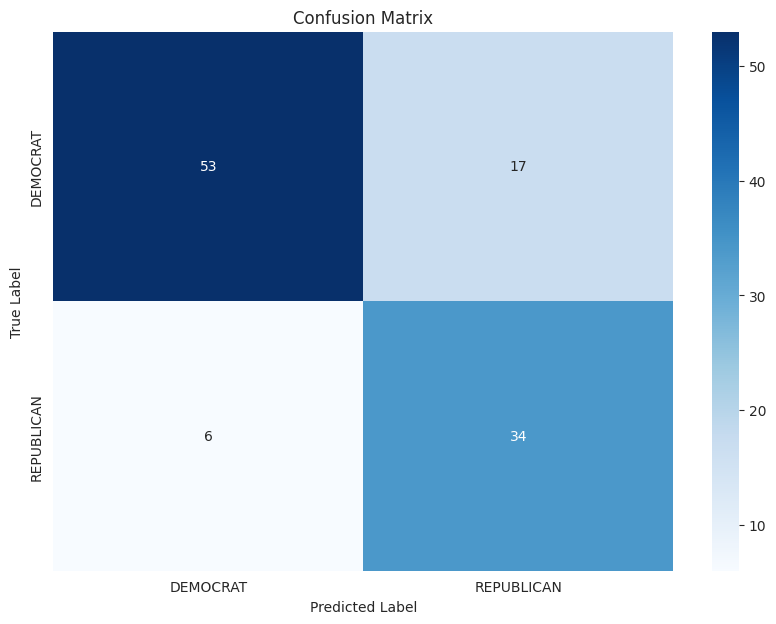

Classification Report:
              precision    recall  f1-score   support

    DEMOCRAT       0.90      0.76      0.82        70
  REPUBLICAN       0.67      0.85      0.75        40

    accuracy                           0.79       110
   macro avg       0.78      0.80      0.78       110
weighted avg       0.81      0.79      0.79       110

            state  year predicted_party actual_party
0         ALABAMA  2020      REPUBLICAN   REPUBLICAN
1          ALASKA  2020      REPUBLICAN   REPUBLICAN
2          ALASKA  2020        DEMOCRAT   REPUBLICAN
3         ARIZONA  2020        DEMOCRAT     DEMOCRAT
4        ARKANSAS  2020      REPUBLICAN   REPUBLICAN
..            ...   ...             ...          ...
57       VIRGINIA  2020        DEMOCRAT     DEMOCRAT
58     WASHINGTON  2020        DEMOCRAT     DEMOCRAT
59  WEST VIRGINIA  2020      REPUBLICAN   REPUBLICAN
60      WISCONSIN  2020        DEMOCRAT     DEMOCRAT
61        WYOMING  2020      REPUBLICAN   REPUBLICAN

[62 rows x 4 

In [ ]:
# Predict and evaluate
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Prepare features for prediction
# Include 'year' in the features
prediction_features = pd.get_dummies(df_2020[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']], columns=['party_simplified'])
prediction_features = prediction_features.reindex(columns=X.columns, fill_value=0)

# Predict
predictions = model.predict(prediction_features)

# Map predictions back to party names
predictions = label_encoder.inverse_transform(predictions)

# Combine states, year, and predictions
results = pd.DataFrame({'state': df_2020['state'].values, 'year': df_2020['year'].values, 'predicted_party': predictions})

# Find actual winners
actual_winners = winner_2020[['state', 'year', 'party_simplified']].rename(columns={'party_simplified': 'actual_party'})

# Merge results with actual winners
results = results.drop_duplicates().merge(actual_winners, on=['state', 'year'])

print(results)

# Training on 1976 - 2016 Data and Testing on 2020 Data


In [ ]:
# Split the data into training and test sets based on year
df_train = modeling_df[modeling_df['year'] <= 2016]
df_test = modeling_df[modeling_df['year'] == 2020]

# Find the party with the maximum votes per state for training and testing
winner_train = df_train.loc[df_train.groupby('state')['candidatevotes'].idxmax()]
winner_train = winner_train[['state', 'year', 'party_simplified']]

winner_test = df_test.loc[df_test.groupby('state')['candidatevotes'].idxmax()]
winner_test = winner_test[['state', 'year', 'party_simplified']]

In [ ]:
# Prepare features and labels for training
features_train = df_train[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_train = pd.get_dummies(features_train, columns=['party_simplified'])
labels_train = winner_train[['state', 'year', 'party_simplified']]

# Encode the labels
label_encoder = LabelEncoder()
labels_train['party_simplified'] = label_encoder.fit_transform(labels_train['party_simplified'])

# Merge features and labels
data_train = features_train.merge(labels_train, on=['state', 'year'])
X_train = data_train.drop(['state', 'year', 'party_simplified'], axis=1)
y_train = data_train['party_simplified']

# Prepare features for testing
features_test = df_test[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_test = pd.get_dummies(features_test, columns=['party_simplified'])



# Random Forest (Training on 1976 - 2016 Data and Testing on 2020 Data)

In [ ]:
# Reindex to match X_train columns, filling missing columns with 0
features_test = features_test.reindex(columns=X_train.columns, fill_value=0)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Prepare features for testing, including 'state' and 'year'
features_test = df_test[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_test = pd.get_dummies(features_test, columns=['party_simplified'])

# Ensure features_test has the same columns as X_train
features_test = features_test.reindex(columns=X_train.columns, fill_value=0)

# Add 'state' and 'year' back to features_test
features_test['state'] = df_test['state'].values
features_test['year'] = df_test['year'].values

# Predict for all rows
y_pred_all = model.predict(features_test.drop(['state', 'year'], axis=1))

# Add predictions to features_test
features_test['party_simplified_pred'] = label_encoder.inverse_transform(y_pred_all)

# Aggregate predictions to get one prediction per state
state_predictions = features_test.groupby('state')['party_simplified_pred'].agg(lambda x: x.mode()[0]).reset_index()

# Aggregate actual winners for comparison
winner_test_aggregated = winner_test.groupby('state')['party_simplified'].agg(lambda x: x.mode()[0]).reset_index()

# Merge with state_predictions to compare
results = state_predictions.merge(winner_test_aggregated, on='state', how='left', suffixes=('_pred', '_actual'))

# Calculate accuracy
accuracy = accuracy_score(results['party_simplified'], results['party_simplified_pred'])
print('Accuracy:', accuracy)

# Print confusion matrix
conf_matrix = confusion_matrix(results['party_simplified'], results['party_simplified_pred'])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.6470588235294118
Confusion Matrix:
[[17  9]
 [ 9 16]]


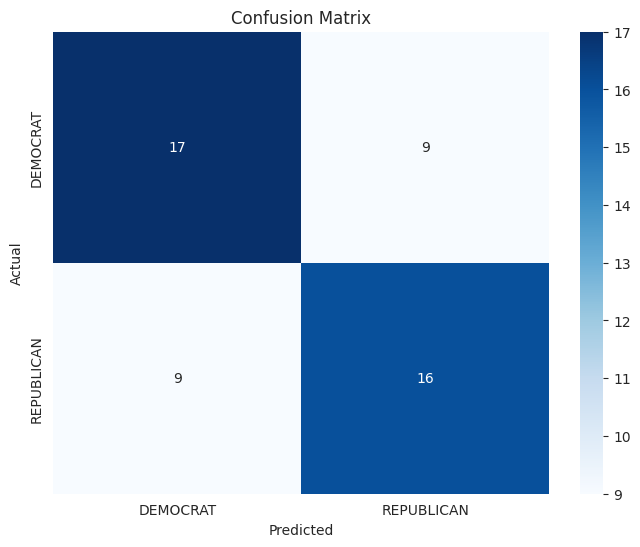

In [ ]:
# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Random Forest Tuning

In [ ]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.8]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the best model
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Prepare features for testing, including 'state' and 'year'
features_test = df_test[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_test = pd.get_dummies(features_test, columns=['party_simplified'])

# Ensure features_test has the same columns as X_train
features_test = features_test.reindex(columns=X_train.columns, fill_value=0)

# Add 'state' and 'year' back to features_test
features_test['state'] = df_test['state'].values
features_test['year'] = df_test['year'].values

# Predict for all rows
y_pred_all = model.predict(features_test.drop(['state', 'year'], axis=1))

# Add predictions to features_test
features_test['party_simplified_pred'] = label_encoder.inverse_transform(y_pred_all)

# Aggregate predictions to get one prediction per state
state_predictions = features_test.groupby('state')['party_simplified_pred'].agg(lambda x: x.mode()[0]).reset_index()

# Aggregate actual winners for comparison
winner_test_aggregated = winner_test.groupby('state')['party_simplified'].agg(lambda x: x.mode()[0]).reset_index()

# Merge with state_predictions to compare
results = state_predictions.merge(winner_test_aggregated, on='state', how='left', suffixes=('_pred', '_actual'))

# Calculate accuracy
accuracy = accuracy_score(results['party_simplified'], results['party_simplified_pred'])
print('Accuracy:', accuracy)

# Print confusion matrix
conf_matrix = confusion_matrix(results['party_simplified'], results['party_simplified_pred'])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.6470588235294118
Confusion Matrix:
[[17  9]
 [ 9 16]]


# Logistic Regression

In [ ]:
# Split the data into training and test sets based on year
df_train = modeling_df[modeling_df['year'] <= 2016]
df_test = modeling_df[modeling_df['year'] == 2020]

# Find the party with the maximum votes per state for training and testing
winner_train = df_train.loc[df_train.groupby('state')['candidatevotes'].idxmax()]
winner_train = winner_train[['state', 'year', 'party_simplified']]

winner_test = df_test.loc[df_test.groupby('state')['candidatevotes'].idxmax()]
winner_test = winner_test[['state', 'year', 'party_simplified']]

# Prepare features and labels for training
features_train = df_train[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_train = pd.get_dummies(features_train, columns=['party_simplified'])
labels_train = winner_train[['state', 'year', 'party_simplified']]

# Encode the labels
label_encoder = LabelEncoder()
labels_train['party_simplified'] = label_encoder.fit_transform(labels_train['party_simplified'])

# Merge features and labels
data_train = features_train.merge(labels_train, on=['state', 'year'])
X_train = data_train.drop(['state', 'year', 'party_simplified'], axis=1)
y_train = data_train['party_simplified']

# Fit the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Prepare features for testing, including 'state' and 'year'
features_test = df_test[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_test = pd.get_dummies(features_test, columns=['party_simplified'])

# Reindex to match X_train columns, filling missing columns with 0
features_test = features_test.reindex(columns=X_train.columns, fill_value=0)

# Add 'state' and 'year' back to features_test
features_test['state'] = df_test['state'].values
features_test['year'] = df_test['year'].values

# Prepare features for testing by dropping 'state' and 'year'
X_test_ready = features_test.drop(['state', 'year'], axis=1)

# Predict for all rows
y_pred_all_encoded = model.predict(X_test_ready)

# Decode predictions
y_pred_all = label_encoder.inverse_transform(y_pred_all_encoded)

# Add predictions to features_test
features_test['party_simplified_pred'] = y_pred_all

# Aggregate predictions to get one prediction per state
state_predictions = features_test.groupby('state')['party_simplified_pred'].agg(lambda x: x.mode()[0]).reset_index()

# Aggregate actual winners for comparison
winner_test_aggregated = winner_test.groupby('state')['party_simplified'].agg(lambda x: x.mode()[0]).reset_index()

# Merge with state_predictions to compare
results = state_predictions.merge(winner_test_aggregated, on='state', how='left', suffixes=('_pred', '_actual'))

# Calculate accuracy
accuracy = accuracy_score(results['party_simplified'], results['party_simplified_pred'])
print('Accuracy:', accuracy)

# Print confusion matrix
conf_matrix = confusion_matrix(results['party_simplified'], results['party_simplified_pred'])
print('Confusion Matrix:')
print(conf_matrix)





Accuracy: 0.5098039215686274
Confusion Matrix:
[[26  0]
 [25  0]]


# Hyper parameter Tuning Logistic Regression

In [ ]:
from imblearn.over_sampling import SMOTE

# Split the data into training and test sets based on year
df_train = modeling_df[modeling_df['year'] <= 2016]
df_test = modeling_df[modeling_df['year'] == 2020]

# Find the party with the maximum votes per state for training and testing
winner_train = df_train.loc[df_train.groupby('state')['candidatevotes'].idxmax()]
winner_train = winner_train[['state', 'year', 'party_simplified']]

winner_test = df_test.loc[df_test.groupby('state')['candidatevotes'].idxmax()]
winner_test = winner_test[['state', 'year', 'party_simplified']]

# Prepare features and labels for training
features_train = df_train[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_train = pd.get_dummies(features_train, columns=['party_simplified'])
labels_train = winner_train[['state', 'year', 'party_simplified']]

# Encode the labels
label_encoder = LabelEncoder()
labels_train['party_simplified'] = label_encoder.fit_transform(labels_train['party_simplified'])

# Merge features and labels
data_train = features_train.merge(labels_train, on=['state', 'year'])
X_train = data_train.drop(['state', 'year', 'party_simplified'], axis=1)
y_train = data_train['party_simplified']

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Fit the Logistic Regression model on the resampled training data
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# Prepare features for testing
features_test = df_test[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_test = pd.get_dummies(features_test, columns=['party_simplified'])

# Reindex to match X_train columns, filling missing columns with 0
features_test = features_test.reindex(columns=X_train.columns, fill_value=0)

# Add 'state' and 'year' back to features_test
features_test['state'] = df_test['state'].values
features_test['year'] = df_test['year'].values

# Prepare features for testing by dropping 'state' and 'year'
X_test_ready = features_test.drop(['state', 'year'], axis=1)

# Predict for all rows
y_pred_all_encoded = model.predict(X_test_ready)

# Decode predictions
y_pred_all = label_encoder.inverse_transform(y_pred_all_encoded)

# Add predictions to features_test
features_test['party_simplified_pred'] = y_pred_all

# Aggregate predictions to get one prediction per state
state_predictions = features_test.groupby('state')['party_simplified_pred'].agg(lambda x: x.mode()[0]).reset_index()

# Aggregate actual winners for comparison
winner_test_aggregated = winner_test.groupby('state')['party_simplified'].agg(lambda x: x.mode()[0]).reset_index()

# Merge with state_predictions to compare
results = state_predictions.merge(winner_test_aggregated, on='state', how='left', suffixes=('_pred', '_actual'))

# Calculate accuracy
accuracy = accuracy_score(results['party_simplified'], results['party_simplified_pred'])
print('Accuracy:', accuracy)

# Print confusion matrix
conf_matrix = confusion_matrix(results['party_simplified'], results['party_simplified_pred'])
print('Confusion Matrix:')
print(conf_matrix)


Accuracy: 0.5098039215686274
Confusion Matrix:
[[26  0]
 [25  0]]


In [ ]:
print(f"Original class distribution:\n{y_train.value_counts()}")
print(f"Resampled class distribution:\n{y_train_resampled.value_counts()}")

Original class distribution:
party_simplified
0    206
1    151
Name: count, dtype: int64
Resampled class distribution:
party_simplified
1    206
0    206
Name: count, dtype: int64


In [ ]:
print("Classification Report:")
print(classification_report(results['party_simplified'], results['party_simplified_pred']))


Classification Report:
              precision    recall  f1-score   support

    DEMOCRAT       0.51      1.00      0.68        26
  REPUBLICAN       0.00      0.00      0.00        25

    accuracy                           0.51        51
   macro avg       0.25      0.50      0.34        51
weighted avg       0.26      0.51      0.34        51



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Split the data into training and test sets based on year
df_train = modeling_df[modeling_df['year'] <= 2016]
df_test = modeling_df[modeling_df['year'] == 2020]

# Find the party with the maximum votes per state for training and testing
winner_train = df_train.loc[df_train.groupby('state')['candidatevotes'].idxmax()]
winner_train = winner_train[['state', 'year', 'party_simplified']]

winner_test = df_test.loc[df_test.groupby('state')['candidatevotes'].idxmax()]
winner_test = winner_test[['state', 'year', 'party_simplified']]

# Prepare features and labels for training
features_train = df_train[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_train = pd.get_dummies(features_train, columns=['party_simplified'])
labels_train = winner_train[['state', 'year', 'party_simplified']]

# Encode the labels
label_encoder = LabelEncoder()
labels_train['party_simplified'] = label_encoder.fit_transform(labels_train['party_simplified'])

# Merge features and labels
data_train = features_train.merge(labels_train, on=['state', 'year'])
X_train = data_train.drop(['state', 'year', 'party_simplified'], axis=1)
y_train = data_train['party_simplified']

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(k_neighbors=10)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the parameter grid for Grid Search (corrected)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear'],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
}

# Perform Grid Search to find the best parameters
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Prepare features for testing
features_test = df_test[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_test = pd.get_dummies(features_test, columns=['party_simplified'])
features_test = features_test.reindex(columns=X_train.columns, fill_value=0)

# Add 'state' and 'year' back to features_test
features_test['state'] = df_test['state'].values
features_test['year'] = df_test['year'].values

# Prepare features for testing by dropping 'state' and 'year'
X_test_ready = features_test.drop(['state', 'year'], axis=1)

# Predict for all rows
y_pred_all_encoded = best_model.predict(X_test_ready)

# Decode predictions
y_pred_all = label_encoder.inverse_transform(y_pred_all_encoded)

# Add predictions to features_test
features_test['party_simplified_pred'] = y_pred_all

# Aggregate predictions to get one prediction per state
state_predictions = features_test.groupby('state')['party_simplified_pred'].agg(lambda x: x.mode()[0]).reset_index()

# Aggregate actual winners for comparison
winner_test_aggregated = winner_test.groupby('state')['party_simplified'].agg(lambda x: x.mode()[0]).reset_index()

# Merge with state_predictions to compare
results = state_predictions.merge(winner_test_aggregated, on='state', how='left', suffixes=('_pred', '_actual'))

# Calculate accuracy
accuracy = accuracy_score(results['party_simplified'], results['party_simplified_pred'])
print('Accuracy:', accuracy)

# Print confusion matrix
conf_matrix = confusion_matrix(results['party_simplified'], results['party_simplified_pred'])
print('Confusion Matrix:')
print(conf_matrix)

# Print classification report
print("Classification Report:")
print(classification_report(results['party_simplified'], results['party_simplified_pred'], zero_division=0))


Best parameters found:
{'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.5294117647058824
Confusion Matrix:
[[17  9]
 [15 10]]
Classification Report:
              precision    recall  f1-score   support

    DEMOCRAT       0.53      0.65      0.59        26
  REPUBLICAN       0.53      0.40      0.45        25

    accuracy                           0.53        51
   macro avg       0.53      0.53      0.52        51
weighted avg       0.53      0.53      0.52        51



# Logistic Regression (Tuned), Random Forest (Tuned) and SVM

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Define parameter grids for different models
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

param_grid_svc = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': [None, 'balanced']
}

# Perform Grid Search for Logistic Regression
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train_resampled, y_train_resampled)
print("Best parameters for Logistic Regression:")
print(grid_search_lr.best_params_)

# Perform Grid Search for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_resampled, y_train_resampled)
print("Best parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Evaluate models
best_model_lr = grid_search_lr.best_estimator_
best_model_rf = grid_search_rf.best_estimator_

# Choose the best model based on performance
# Evaluate the chosen model on the test set and generate reports as before


Best parameters for Logistic Regression:
{'C': 100, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Best parameters for Random Forest:
{'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Perform Grid Search for SVM
grid_search_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc.fit(X_train_resampled, y_train_resampled)
print("Best parameters for SVM:")
print(grid_search_svc.best_params_)

# Evaluate model
best_model_svc = grid_search_svc.best_estimator_

# XGBoost, Neural Network and KNN

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Split the data into training and test sets based on year
df_train = modeling_df[modeling_df['year'] <= 2016]
df_test = modeling_df[modeling_df['year'] == 2020]

# Find the party with the maximum votes per state for training and testing
winner_train = df_train.loc[df_train.groupby('state')['candidatevotes'].idxmax()]
winner_train = winner_train[['state', 'year', 'party_simplified']]

winner_test = df_test.loc[df_test.groupby('state')['candidatevotes'].idxmax()]
winner_test = winner_test[['state', 'year', 'party_simplified']]

# Prepare features and labels for training
features_train = df_train[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_train = pd.get_dummies(features_train, columns=['party_simplified'])
labels_train = winner_train[['state', 'year', 'party_simplified']]

# Encode the labels
label_encoder = LabelEncoder()
labels_train['party_simplified'] = label_encoder.fit_transform(labels_train['party_simplified'])

# Merge features and labels
data_train = features_train.merge(labels_train, on=['state', 'year'])
X_train = data_train.drop(['state', 'year', 'party_simplified'], axis=1)
y_train = data_train['party_simplified']

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# XGBoost model
xgb_model = XGBClassifier(n_estimators=100, max_depth=3, scale_pos_weight=1)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, activation='relu', solver='adam')
nn_model.fit(X_train_resampled, y_train_resampled)

# k-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_resampled, y_train_resampled)

# Prepare features for testing
features_test = df_test[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_test = pd.get_dummies(features_test, columns=['party_simplified'])

# Reindex to match X_train columns, filling missing columns with 0
features_test = features_test.reindex(columns=X_train.columns, fill_value=0)

# Add 'state' and 'year' back to features_test
features_test['state'] = df_test['state'].values
features_test['year'] = df_test['year'].values

# Prepare features for testing by dropping 'state' and 'year'
X_test_ready = features_test.drop(['state', 'year'], axis=1)

# Predict using XGBoost
y_pred_xgb_encoded = xgb_model.predict(X_test_ready)
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

# Predict using Neural Network
y_pred_nn_encoded = nn_model.predict(X_test_ready)
y_pred_nn = label_encoder.inverse_transform(y_pred_nn_encoded)

# Predict using k-Nearest Neighbors
y_pred_knn_encoded = knn_model.predict(X_test_ready)
y_pred_knn = label_encoder.inverse_transform(y_pred_knn_encoded)

# Add predictions to features_test
features_test['party_simplified_pred_xgb'] = y_pred_xgb
features_test['party_simplified_pred_nn'] = y_pred_nn
features_test['party_simplified_pred_knn'] = y_pred_knn

# Aggregate predictions to get one prediction per state for each model
state_predictions_xgb = features_test.groupby('state')['party_simplified_pred_xgb'].agg(lambda x: x.mode()[0]).reset_index()
state_predictions_nn = features_test.groupby('state')['party_simplified_pred_nn'].agg(lambda x: x.mode()[0]).reset_index()
state_predictions_knn = features_test.groupby('state')['party_simplified_pred_knn'].agg(lambda x: x.mode()[0]).reset_index()

# Aggregate actual winners for comparison
winner_test_aggregated = winner_test.groupby('state')['party_simplified'].agg(lambda x: x.mode()[0]).reset_index()

# Merge with state_predictions to compare
results_xgb = state_predictions_xgb.merge(winner_test_aggregated, on='state', how='left', suffixes=('_pred', '_actual'))
results_nn = state_predictions_nn.merge(winner_test_aggregated, on='state', how='left', suffixes=('_pred', '_actual'))
results_knn = state_predictions_knn.merge(winner_test_aggregated, on='state', how='left', suffixes=('_pred', '_actual'))

# Calculate accuracy and confusion matrix for each model
for model_name, results, pred_col in [('XGBoost', results_xgb, 'party_simplified_pred_xgb'),
                                      ('Neural Network', results_nn, 'party_simplified_pred_nn'),
                                      ('k-NN', results_knn, 'party_simplified_pred_knn')]:
    accuracy = accuracy_score(results['party_simplified'], results[pred_col])
    print(f'{model_name} Accuracy:', accuracy)

    conf_matrix = confusion_matrix(results['party_simplified'], results[pred_col])
    print(f'{model_name} Confusion Matrix:')
    print(conf_matrix)

    class_report = classification_report(results['party_simplified'], results[pred_col])
    print(f'{model_name} Classification Report:')
    print(class_report)
    print('-' * 60)



# Hyperperameter Tuning XGBoost, Neural Network and KNN

In [ ]:
# Split the data into training and test sets based on year
df_train = modeling_df[modeling_df['year'] <= 2016]
df_test = modeling_df[modeling_df['year'] == 2020]

# Find the party with the maximum votes per state for training and testing
winner_train = df_train.loc[df_train.groupby('state')['candidatevotes'].idxmax()]
winner_train = winner_train[['state', 'year', 'party_simplified']]

winner_test = df_test.loc[df_test.groupby('state')['candidatevotes'].idxmax()]
winner_test = winner_test[['state', 'year', 'party_simplified']]

# Prepare features and labels for training
features_train = df_train[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_train = pd.get_dummies(features_train, columns=['party_simplified'])
labels_train = winner_train[['state', 'year', 'party_simplified']]

# Encode the labels
label_encoder = LabelEncoder()
labels_train['party_simplified'] = label_encoder.fit_transform(labels_train['party_simplified'])

# Merge features and labels
data_train = features_train.merge(labels_train, on=['state', 'year'])
X_train = data_train.drop(['state', 'year', 'party_simplified'], axis=1)
y_train = data_train['party_simplified']

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize models
models = {
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=3, scale_pos_weight=1),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, activation='relu', solver='adam'),
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Train, predict and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    print(f'{model_name} Cross-Validation Accuracy: {cv_scores.mean()} (+/- {cv_scores.std()})')

    # Prepare features for testing
    features_test = df_test[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
    features_test = pd.get_dummies(features_test, columns=['party_simplified'])

    # Reindex to match X_train columns, filling missing columns with 0
    features_test = features_test.reindex(columns=X_train.columns, fill_value=0)

    # Add 'state' and 'year' back to features_test
    features_test['state'] = df_test['state'].values
    features_test['year'] = df_test['year'].values

    # Prepare features for testing by dropping 'state' and 'year'
    X_test_ready = features_test.drop(['state', 'year'], axis=1)

    # Predict using the model
    y_pred_encoded = model.predict(X_test_ready)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Add predictions to features_test
    features_test[f'party_simplified_pred_{model_name.lower().replace(" ", "_")}'] = y_pred

    # Aggregate predictions to get one prediction per state for the model
    state_predictions = features_test.groupby('state')[f'party_simplified_pred_{model_name.lower().replace(" ", "_")}'].agg(lambda x: x.mode()[0]).reset_index()

    # Aggregate actual winners for comparison
    winner_test_aggregated = winner_test.groupby('state')['party_simplified'].agg(lambda x: x.mode()[0]).reset_index()

    # Merge with state_predictions to compare
    results = state_predictions.merge(winner_test_aggregated, on='state', how='left', suffixes=('_pred', '_actual'))

    # Check if the column 'party_simplified_pred' exists in results
    pred_col = f'party_simplified_pred_{model_name.lower().replace(" ", "_")}'
    if pred_col not in results.columns:
        raise KeyError(f"Prediction column {pred_col} not found in results")

    # Calculate accuracy and confusion matrix for the model
    accuracy = accuracy_score(results['party_simplified'], results[pred_col])
    print(f'{model_name} Accuracy:', accuracy)

    conf_matrix = confusion_matrix(results['party_simplified'], results[pred_col])
    print(f'{model_name} Confusion Matrix:')
    print(conf_matrix)

    class_report = classification_report(results['party_simplified'], results[pred_col])
    print(f'{model_name} Classification Report:')
    print(class_report)
    print('-' * 60)


In [ ]:
# Split the data into training and test sets based on year
df_train = modeling_df[modeling_df['year'] <= 2016]
df_test = modeling_df[modeling_df['year'] == 2020]

# Find the party with the maximum votes per state for training and testing
winner_train = df_train.loc[df_train.groupby('state')['candidatevotes'].idxmax()]
winner_train = winner_train[['state', 'year', 'party_simplified']]

winner_test = df_test.loc[df_test.groupby('state')['candidatevotes'].idxmax()]
winner_test = winner_test[['state', 'year', 'party_simplified']]

# Prepare features and labels for training
features_train = df_train[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_train = pd.get_dummies(features_train, columns=['party_simplified'])
labels_train = winner_train[['state', 'year', 'party_simplified']]

# Encode the labels
label_encoder = LabelEncoder()
labels_train['party_simplified'] = label_encoder.fit_transform(labels_train['party_simplified'])

# Merge features and labels
data_train = features_train.merge(labels_train, on=['state', 'year'])
X_train = data_train.drop(['state', 'year', 'party_simplified'], axis=1)
y_train = data_train['party_simplified']

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize models
models = {
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=3, scale_pos_weight=1),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, activation='relu', solver='adam'),
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Plotting function for confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Train, predict and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    print(f'{model_name} Cross-Validation Accuracy: {cv_scores.mean()} (+/- {cv_scores.std()})')

    # Prepare features for testing
    features_test = df_test[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
    features_test = pd.get_dummies(features_test, columns=['party_simplified'])

    # Reindex to match X_train columns, filling missing columns with 0
    features_test = features_test.reindex(columns=X_train.columns, fill_value=0)

    # Add 'state' and 'year' back to features_test
    features_test['state'] = df_test['state'].values
    features_test['year'] = df_test['year'].values

    # Prepare features for testing by dropping 'state' and 'year'
    X_test_ready = features_test.drop(['state', 'year'], axis=1)

    # Predict using the model
    y_pred_encoded = model.predict(X_test_ready)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Add predictions to features_test
    features_test[f'party_simplified_pred_{model_name.lower().replace(" ", "_")}'] = y_pred

    # Aggregate predictions to get one prediction per state for the model
    state_predictions = features_test.groupby('state')[f'party_simplified_pred_{model_name.lower().replace(" ", "_")}'].agg(lambda x: x.mode()[0]).reset_index()

    # Aggregate actual winners for comparison
    winner_test_aggregated = winner_test.groupby('state')['party_simplified'].agg(lambda x: x.mode()[0]).reset_index()

    # Merge with state_predictions to compare
    results = state_predictions.merge(winner_test_aggregated, on='state', how='left', suffixes=('_pred', '_actual'))

    # Check if the column 'party_simplified_pred' exists in results
    pred_col = f'party_simplified_pred_{model_name.lower().replace(" ", "_")}'
    if pred_col not in results.columns:
        raise KeyError(f"Prediction column {pred_col} not found in results")

    # Calculate accuracy and confusion matrix for the model
    accuracy = accuracy_score(results['party_simplified'], results[pred_col])
    print(f'{model_name} Accuracy:', accuracy)

    conf_matrix = confusion_matrix(results['party_simplified'], results[pred_col])
    print(f'{model_name} Confusion Matrix:')
    print(conf_matrix)

    # Plot confusion matrix
    plot_confusion_matrix(conf_matrix, model_name)

    class_report = classification_report(results['party_simplified'], results[pred_col])
    print(f'{model_name} Classification Report:')
    print(class_report)
    print('-' * 60)


# Ensemble Methods

In [ ]:
# Split the data into training and test sets based on year
df_train = modeling_df[modeling_df['year'] <= 2016]
df_test = modeling_df[modeling_df['year'] == 2020]

# Find the party with the maximum votes per state for training and testing
winner_train = df_train.loc[df_train.groupby('state')['candidatevotes'].idxmax()]
winner_train = winner_train[['state', 'year', 'party_simplified']]

winner_test = df_test.loc[df_test.groupby('state')['candidatevotes'].idxmax()]
winner_test = winner_test[['state', 'year', 'party_simplified']]

# Prepare features and labels for training
features_train = df_train[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_train = pd.get_dummies(features_train, columns=['party_simplified'])
labels_train = winner_train[['state', 'year', 'party_simplified']]

# Encode the labels
label_encoder = LabelEncoder()
labels_train['party_simplified'] = label_encoder.fit_transform(labels_train['party_simplified'])

# Merge features and labels
data_train = features_train.merge(labels_train, on=['state', 'year'])
X_train = data_train.drop(['state', 'year', 'party_simplified'], axis=1)
y_train = data_train['party_simplified']

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Prepare features for testing
features_test = df_test[['state', 'year', 'candidatevotes', 'totalvotes', 'party_simplified']]
features_test = pd.get_dummies(features_test, columns=['party_simplified'])

# Reindex to match X_train columns, filling missing columns with 0
features_test = features_test.reindex(columns=X_train.columns, fill_value=0)

# Add 'state' and 'year' back to features_test
features_test['state'] = df_test['state'].values
features_test['year'] = df_test['year'].values

# Prepare features for testing by dropping 'state' and 'year'
X_test_ready = features_test.drop(['state', 'year'], axis=1)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l1', solver='liblinear'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, activation='relu', solver='adam'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

# Train, predict, and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Predict on test set
    y_pred_encoded = model.predict(X_test_ready)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Add predictions to features_test
    features_test['party_simplified_pred'] = y_pred

    # Aggregate predictions to get one prediction per state
    state_predictions = features_test.groupby('state')['party_simplified_pred'].agg(lambda x: x.mode()[0]).reset_index()

    # Aggregate actual winners for comparison
    winner_test_aggregated = winner_test.groupby('state')['party_simplified'].agg(lambda x: x.mode()[0]).reset_index()

    # Merge with state_predictions to compare
    results = state_predictions.merge(winner_test_aggregated, on='state', how='left', suffixes=('_pred', '_actual'))

    # Calculate accuracy
    accuracy = accuracy_score(results['party_simplified'], results['party_simplified_pred'])
    print(f'Accuracy for {model_name}:', accuracy)

    # Print confusion matrix
    conf_matrix = confusion_matrix(results['party_simplified'], results['party_simplified_pred'])
    print(f'Confusion Matrix for {model_name}:')
    print(conf_matrix)

    # Print classification report
    class_report = classification_report(results['party_simplified'], results['party_simplified_pred'])
    print(f'Classification Report for {model_name}:')
    print(class_report)
    print('-' * 60)


# Different approach using electoral college votes won based on the predicted states won.

In [ ]:
# List of states
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
          'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
          'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
          'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
          'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
          'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
          'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia',
          'Wisconsin', 'Wyoming']

# Capitalize state names
capitalized_states = [state.upper() for state in states]

# Electoral votes data
electoral_votes = {
    'state': capitalized_states,
    'electoral_votes': [9, 3, 11, 6, 55, 9, 7, 3, 29, 16, 4, 4, 20, 11, 6, 6, 8, 8, 4, 10, 11, 16, 10, 6, 10,
                        3, 5, 6, 4, 14, 5, 29, 15, 3, 18, 7, 7, 20, 4, 9, 3, 11, 38, 6, 3, 13, 12, 5, 10, 3]
}

# Create DataFrame from electoral votes data
electoral_votes_df = pd.DataFrame(electoral_votes)

#print(electoral_votes_df)

# Preprocessing the data to prepare for the machine learning models.

In [ ]:
# Aggregate votes by party, state, and year
party_votes = modeling_df.groupby(['year', 'state', 'party_detailed'])['candidatevotes'].sum().reset_index()

# Ensure there is only one winner per state per year
party_votes = party_votes.sort_values(by=['year', 'state', 'candidatevotes'], ascending=[True, True, False])
party_votes['rank'] = party_votes.groupby(['year', 'state'])['candidatevotes'].rank(method='first', ascending=False)

# Filter to keep only the top-ranked party for each state and year
winning_party = party_votes[party_votes['rank'] == 1].drop(columns=['rank'])

# Create a DataFrame with the winning party for each state and year
winner_table = winning_party[['year', 'state', 'party_detailed']]
winner_table.rename(columns={'party_detailed': 'winning_party'}, inplace=True)

# Aggregate votes by party, state, and year
party_votes = modeling_df.groupby(['year', 'state', 'party_detailed'])['candidatevotes'].sum().reset_index()

# Ensure there is only one winner per state per year
party_votes = party_votes.sort_values(by=['year', 'state', 'candidatevotes'], ascending=[True, True, False])
party_votes['rank'] = party_votes.groupby(['year', 'state'])['candidatevotes'].rank(method='first', ascending=False)

# Filter to keep only the top-ranked party for each state and year
winning_party = party_votes[party_votes['rank'] == 1].drop(columns=['rank'])

# Create a DataFrame with the winning party for each state and year
winner_table = winning_party[['year', 'state', 'party_detailed']]
winner_table.rename(columns={'party_detailed': 'winning_party'}, inplace=True)

# Calculate previous winning party
winner_table['previous_winning_party'] = winner_table.groupby('state')['winning_party'].shift(1)

# Merge winner table with electoral votes
winner_table = winner_table.merge(electoral_votes_df, on='state', how='left')

# Prepare data for training (1976-2016) and testing (2020)
train_data = winner_table[(winner_table['year'] >= 1976) & (winner_table['year'] <= 2016)]
test_data = winner_table[winner_table['year'] == 2020]

# Prepare the training data
X_train = train_data[['year', 'state', 'previous_winning_party']]
y_train = train_data['winning_party']

# Prepare data for a specific year to predict (e.g., 2020)
X_test = test_data[['year', 'state', 'previous_winning_party']]
y_test = test_data['winning_party']  # Actual labels for comparison

# Encode categorical features
X_train = pd.get_dummies(X_train, columns=['state', 'previous_winning_party'])
X_test = pd.get_dummies(X_test, columns=['state', 'previous_winning_party'])

# Ensure X_train and X_test have the same columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [ ]:
# Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga']
}

# MLPClassifier
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],  # Limited to 'relu' for simplicity
    'solver': ['adam'],  # Limited to 'adam'
    'alpha': [0.0001, 0.001],  # Reduced alpha values
    'learning_rate': ['constant'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200, 500]
}

# Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Define RandomizedSearchCV for MLPClassifier
random_search_mlp = RandomizedSearchCV(
    MLPClassifier(random_state=42),
    param_distributions=param_grid_mlp,
    n_iter=5,  # Number of random combinations to sample
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all available CPU cores
    random_state=42
)

# Define a function to train and evaluate models with cross-validation
def train_and_evaluate_model(clf, X_train, y_train, X_test, y_test, test_data, param_grid=None, search_type='grid'):
    if param_grid:
        if search_type == 'grid':
            search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        elif search_type == 'random':
            search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
    else:
        best_model = clf
        best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=test_data['winning_party'].unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data['winning_party'].unique())
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()

    test_predictions = pd.DataFrame(X_test.copy())
    test_predictions['predicted_winning_party'] = y_pred
    test_predictions['state'] = test_data['state'].values
    test_predictions['electoral_votes'] = test_data['electoral_votes'].values

    electoral_votes_by_party_2020 = test_predictions.groupby('predicted_winning_party')['electoral_votes'].sum()
    overall_winner = electoral_votes_by_party_2020.idxmax()
    print(f'The overall predicted winner for 2020 is: {overall_winner}')

    print("\nElectoral votes won by each party in 2020:")
    for party, votes in electoral_votes_by_party_2020.items():
        print(f"{party}: {votes} electoral votes")

    for party in electoral_votes_by_party_2020.index:
        states_won = test_predictions[test_predictions['predicted_winning_party'] == party]['state'].tolist()
        print(f"\nThe {party} party won {len(states_won)} states. They are: {', '.join(states_won)}")

    # Print classification report
    print(f'Classification Report:')
    print(classification_report(y_test, y_pred))
    print('-' * 60)

# Train and test models

Random Forest Classifier

In [ ]:
# RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(clf_rf, X_train, y_train, X_test, y_test, test_data)

Logistic Regression

In [ ]:
# LogisticRegression with GridSearchCV (l1, l2 penalties)
clf_lr = LogisticRegression(random_state=42)
train_and_evaluate_model(clf_lr, X_train, y_train, X_test, y_test, test_data, param_grid_lr)

Gradient Boosting Classifier

In [ ]:
# GradientBoostingClassifier with GridSearchCV
clf_gb = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(clf_gb, X_train, y_train, X_test, y_test, test_data, param_grid_gb, search_type='random')

Support Vector Machine

In [ ]:
# SVM
clf_svm = SVC(random_state=42)
train_and_evaluate_model(clf_svm, X_train, y_train, X_test, y_test, test_data)

Multi-Layer Perceptron Classifier (MLPC)

In [ ]:
# MLPClassifier with GridSearchCV
clf_mlp = MLPClassifier(random_state=42)
train_and_evaluate_model(clf_mlp, X_train, y_train, X_test, y_test, test_data, param_grid_mlp)

# Predict 2024 Result

In [ ]:
# Split the data
train_data = modeling_df[modeling_df['year'] < 2020]
test_data = modeling_df[modeling_df['year'] == 2020]
predict_data = modeling_df[modeling_df['year'] == 2024]

# Define features and target
features = ['state', 'candidate', 'party_detailed', 'candidatevotes', 'totalvotes']
target = 'party_simplified'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]
X_predict = predict_data[features]

# Encode categorical features
label_encoders = {}
for feature in ['state', 'candidate', 'party_detailed']:
    le = LabelEncoder()
    # Fit on the combined data to ensure all possible labels are seen
    le.fit(pd.concat([X_train[feature], X_test[feature], X_predict[feature]]).astype(str))
    X_train[feature] = le.transform(X_train[feature].astype(str))
    X_test[feature] = le.transform(X_test[feature].astype(str))
    X_predict[feature] = le.transform(X_predict[feature].astype(str))
    label_encoders[feature] = le

# Encode target variable
target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(y_train)
y_test = target_encoder.transform(y_test)

# Initialize models
rf_model = RandomForestClassifier()

# Train models
rf_model.fit(X_train, y_train)

# Evaluate models
rf_y_pred_test = rf_model.predict(X_test)

print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_y_pred_test))
print("Random Forest Classification Report:\n", classification_report(y_test, rf_y_pred_test))

# Predict future results
rf_y_pred_future = rf_model.predict(X_predict)

# Decode predictions
rf_predictions = target_encoder.inverse_transform(rf_y_pred_future)

predict_data['rf_predicted_party'] = rf_predictions

print("Random Forest Predictions for 2024:")
print(predict_data[['state', 'candidate', 'rf_predicted_party']])